


---


# P7 - Implémentez un modèle de scoring

---
La société financière  "Prêt à dépenser"propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé.
**Missions**
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Dans le présent Notebook , je présente la partie analyse explratoire des données

In [1]:
#les bibliothèques essentielles
import pandas as pd
import seaborn as sns
import glob
import pickle
import os
import gc
from sklearn.preprocessing import LabelEncoder
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)


#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })



---


## LES FONCTIONS

---

In [3]:
def ValueNaN(data):
    '''Control des valeurs manquantes'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data



In [4]:
def plot_histogram(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(15,5)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index,color=sns.set_palette("pastel"))
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()



In [5]:
def plot_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(15,5)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage de cible avec défaut de remboursement ")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()


In [6]:
#Plot distribution of one feature
def plot_kde(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    show()   


# Analyse exploratoire des données

In [7]:
%%time 
PATH="C:/Users/mimil/p7-data"
application_train = pd.read_csv(PATH +'/application_train.csv')
application_test = pd.read_csv(PATH+'/application_test.csv')
bureau = pd.read_csv(PATH+'/bureau.csv')
bureau_balance = pd.read_csv(PATH+'/bureau_balance.csv')
credit_card_balance = pd.read_csv(PATH+'/credit_card_balance.csv')
installments_payments = pd.read_csv(PATH+'/installments_payments.csv')
POS_CASH_balance = pd.read_csv(PATH+'/POS_CASH_balance.csv')
previous_application = pd.read_csv(PATH+'/previous_application.csv')
description = pd.read_csv(PATH+'/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")



CPU times: total: 1min
Wall time: 1min 4s


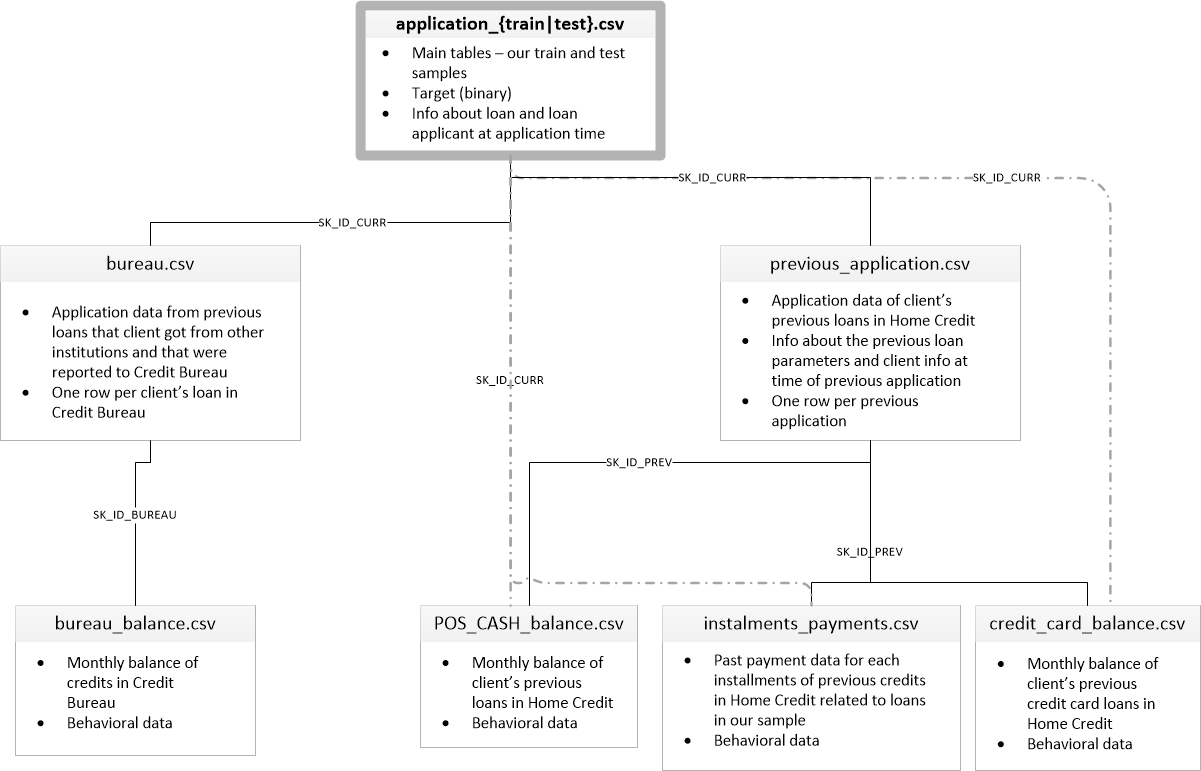

Le jeu de données se compose de 8 tables :


| Dataframe | Signification |
| --- | --- | 
| application_train/application_test | Les données principales d'entraînement et de test contiennent des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par  *SK_ID_CURR*. Les données d'application_train contiennet la TARGET qui indique 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. |  
| bureau | Les données concernent les précédents crédits des clients provenant d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau, mais un prêt dans les données d'application peut avoir plusieurs crédits précédents. | 
| bureau_balance | Soldes mensuels des crédits précédents dans Credit Bureau.Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes. | 
| POS_CASH_balance | Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit. | 
| credit_card_balance | Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. |
| previous_application | Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon. | 
| installments_payments |Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. | 
| HomeCredit_columns_description| Ce fichier contient les descriptions des colonnes des différents fichiers de données. | 

In [8]:
print("La documentations des CSV :")
pd.set_option("max_colwidth", 400)
# Affichage du dataframe en masquant l'index
description_styled = description[['Table','Row','Description','Special']].style.hide(axis="index")
description_styled

La documentations des CSV :


Table,Row,Description,Special
application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,nan
application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",nan
application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,nan
application_{train|test}.csv,CODE_GENDER,Gender of the client,nan
application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,nan
application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,nan
application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,nan
application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,nan
application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,nan
application_{train|test}.csv,AMT_ANNUITY,Loan annuity,nan




---

## 1- Analyse exploratoire de "application_train.csv" et "application_test.csv" :

---

application_train et application_test represent les fichiers de bases pour notre analyse des données


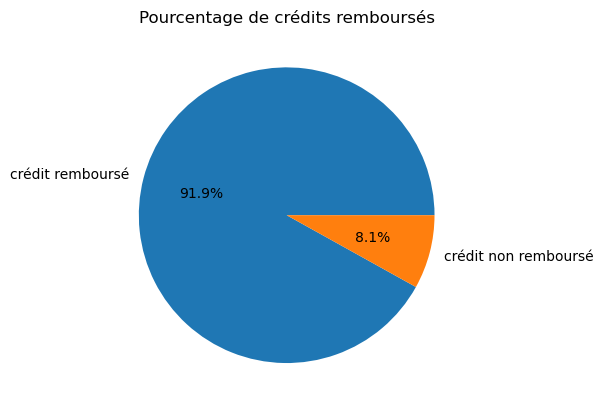

In [9]:
#etude de la target 
fig = plt.figure()
plt.pie(application_train['TARGET'].value_counts()/len(application_train)*100,
        autopct='%1.1f%%',
        labels=["crédit remboursé", "crédit non remboursé"]
       )
plt.title('Pourcentage de crédits remboursés')
plt.show()




À partir de la distribution de la variable cible, une chose que nous pouvons rapidement remarquer est le déséquilibre des données. Seulement 8,07% des prêts au total ont effectivement été en défaut. Cela signifie que les défaillants constituent la classe minoritaire.
D'autre part, 91,9% des prêts n'ont pas été en défaut. Ainsi, les non-défaillants constituent notre classe majoritaire.


In [10]:
#le nombre de chaque type dans le dataframe
application_train.dtypes.value_counts()


float64    65
int64      41
object     16
dtype: int64

Des variables catégorielles et numériques , on va vérifier le nombre de valeurs uniques pour chaque variable catégorielle afin de choisir l'encodage adéquat 

In [11]:
#nombre de valeurs uniques pour chaque variable categorielle
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

4 variables catégorielles binaires , le reste avec plus de 3 valeurs

### valeurs manquantes ( application_train )

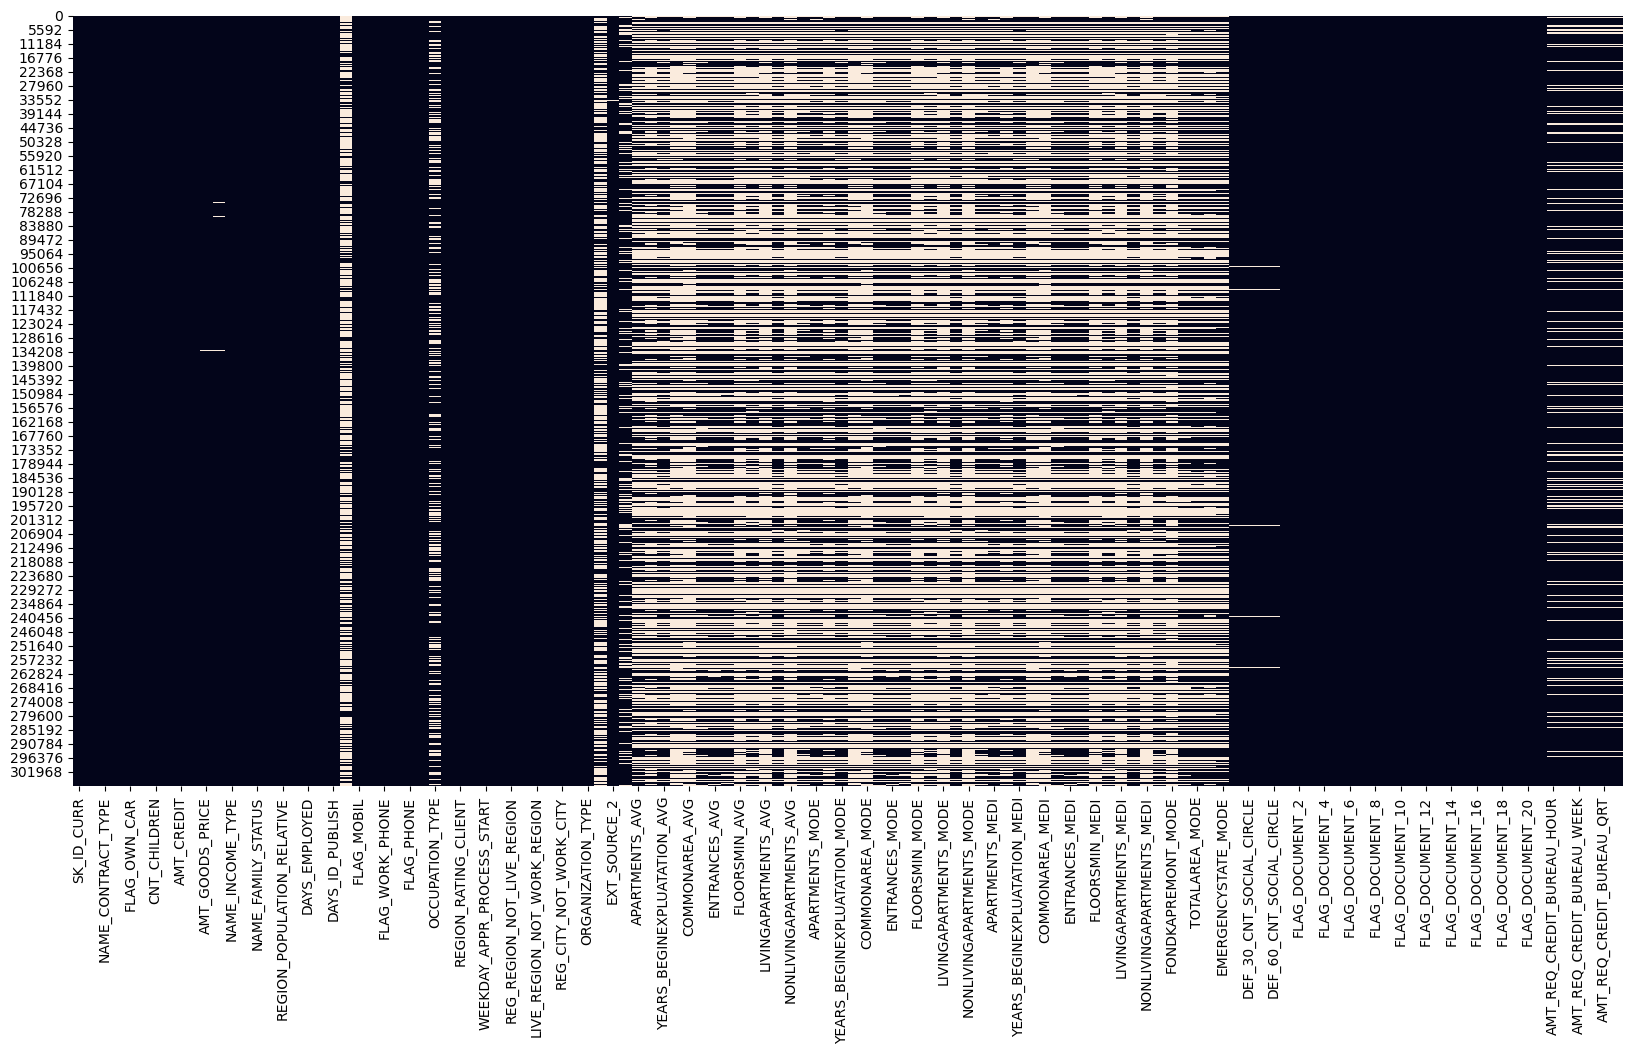

In [12]:
#vue globale des valeurs manquantes
plt.figure(figsize=(20,10))
sns.heatmap(application_train.isna(), cbar=False)
show()

In [13]:
print("Nb de colonnes dans application_train: " + str(len(ValueNaN(application_train))))

print("Nb de colonnes avec des NaN: " + 
      str(len(ValueNaN(application_train)[ValueNaN(application_train)['Total']!=0])))


Nb de colonnes dans application_train: 122
Nb de colonnes avec des NaN: 67


In [14]:
# les valeurs 
print('Les TOP 10 features avec  des valeurs manquantes dans application_train')
ValueNaN(application_train)[:10]

Les TOP 10 features avec  des valeurs manquantes dans application_train


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35




---


###Les valeurs aberrantes dans (application_train) : 


---



- **La colonne 'CODE_GENDER'** :
contient 4 valeurs avec XNA ( valeur inconnue ou manquantes ) comme le jeu de données contient assez de données , je supprime ces 4 valeurs

In [15]:
application_train['CODE_GENDER'].nunique

<bound method IndexOpsMixin.nunique of 0         M
1         F
2         M
3         F
4         M
         ..
307506    M
307507    F
307508    F
307509    F
307510    F
Name: CODE_GENDER, Length: 307511, dtype: object>

In [16]:
application_train=application_train[application_train['CODE_GENDER']!='XNA']


- **La colonne 'DAYS_BIRTH'** :
'DAYS_BIRTH' ont des valeurs négatives. Il est donc important de pouvoir analyser et si besoin rectifier ce type de données.


In [17]:
application_train['DAYS_BIRTH'].describe()

count    307507.0000
mean     -16037.0273
std        4363.9824
min      -25229.0000
25%      -19682.0000
50%      -15750.0000
75%      -12413.0000
max       -7489.0000
Name: DAYS_BIRTH, dtype: float64

Les valeurs de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Il est nécessaire de modifier cette variable pour obtenir des chiffres plus compréhensibles pour l'analyse comme l'age.



In [18]:
(application_train['DAYS_BIRTH'] / -365).describe()



count    307507.0000
mean         43.9371
std          11.9561
min          20.5178
25%          34.0082
50%          43.1507
75%          53.9233
max          69.1205
Name: DAYS_BIRTH, dtype: float64

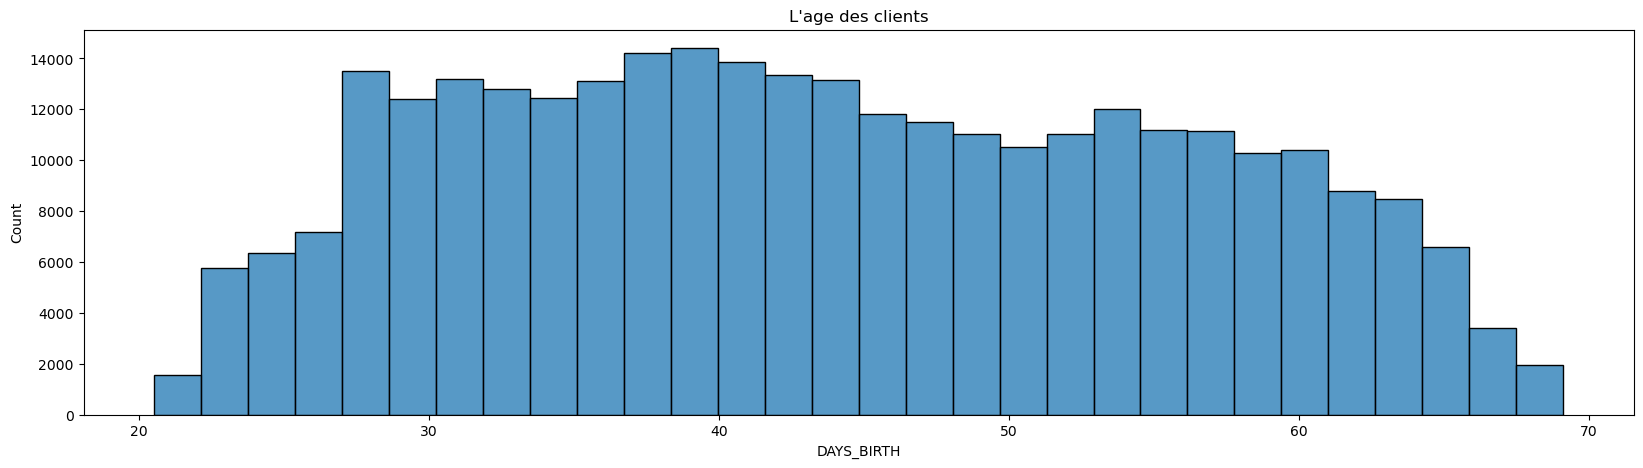

In [19]:
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('L\'age des clients')
show()


- **La colonne 'DAYS_EMPLOYED'**

In [20]:
application_train['DAYS_EMPLOYED'].describe()


count    307507.0000
mean      63815.9292
std      141276.4725
min      -17912.0000
25%       -2760.0000
50%       -1213.0000
75%        -289.0000
max      365243.0000
Name: DAYS_EMPLOYED, dtype: float64

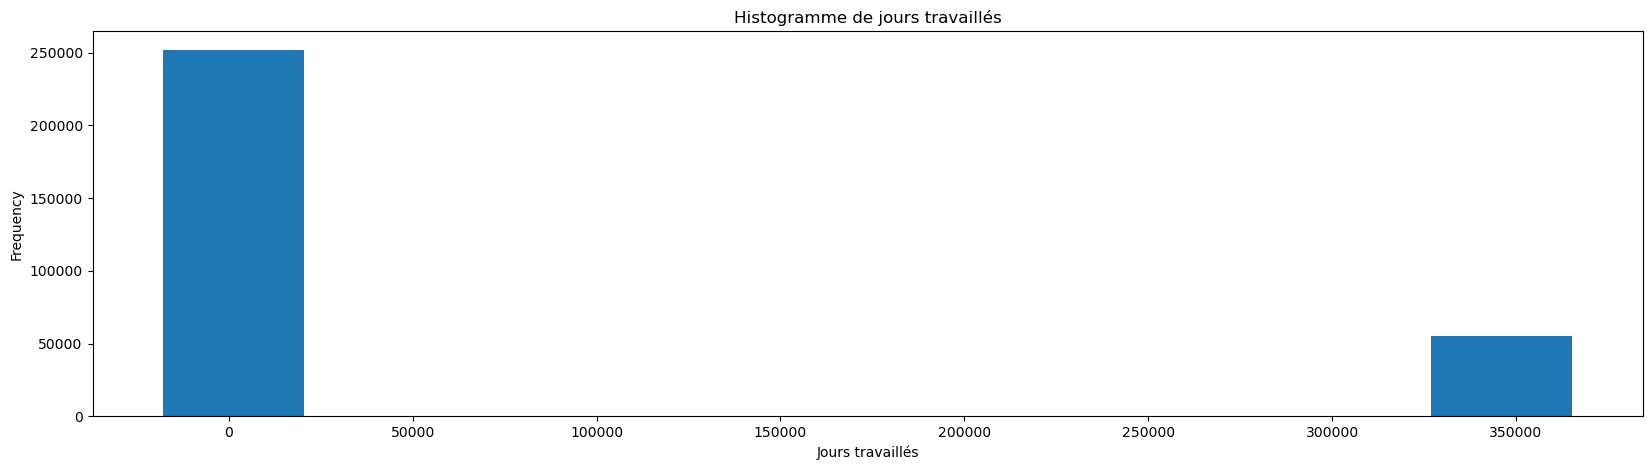

In [21]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme de jours travaillés', figsize=(20,5));
plt.xlabel('Jours travaillés')
show()


Présence d'une valeur aberrante au sens où le Max. représente 1000 années (365243/365j). Est-ce un individu isolé? Plusieurs individus de l'échantillon?



In [22]:
print("%0.0f valeurs avec 365243 jours travaillés pour application_train" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Valeurs totales des jours d'emploi pour application_train" % application_train.shape[0])
print("***********************")
print("%0.0f valeurs avec 365243 jours travaillés pour application_test" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Valeurs totales des jours d'emploi pour application_test" % application_test.shape[0])


55374 valeurs avec 365243 jours travaillés pour application_train
307507 Valeurs totales des jours d'emploi pour application_train
***********************
9274 valeurs avec 365243 jours travaillés pour application_test
48744 Valeurs totales des jours d'emploi pour application_test


In [23]:
#Creaation d'un flag pour outliers
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#Replace outliers values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


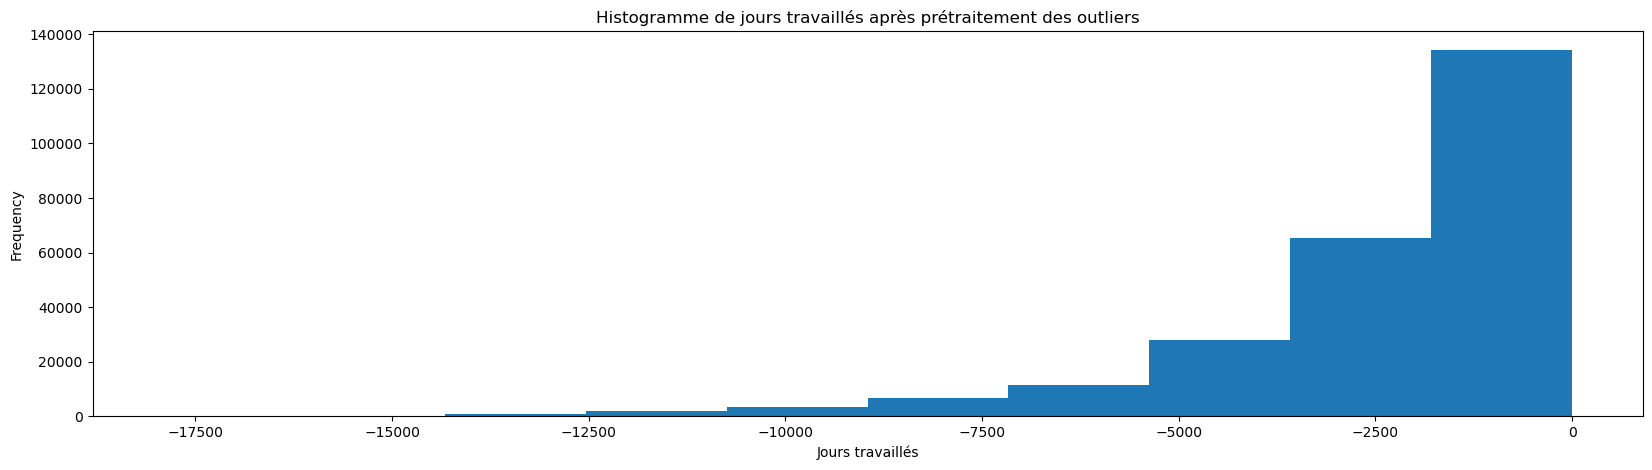

In [24]:
application_train['DAYS_EMPLOYED'].plot.hist(title ='Histogramme de jours travaillés après prétraitement des outliers', figsize=(20,5))
plt.xlabel('Jours travaillés')
show()




---


### Choix des varaibles sélectives


---
Le choix des features pouvant être explicatives est très important. Ici l'idée est simplement d'avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.




<**NAME_CONTRACT_TYPE**>


---




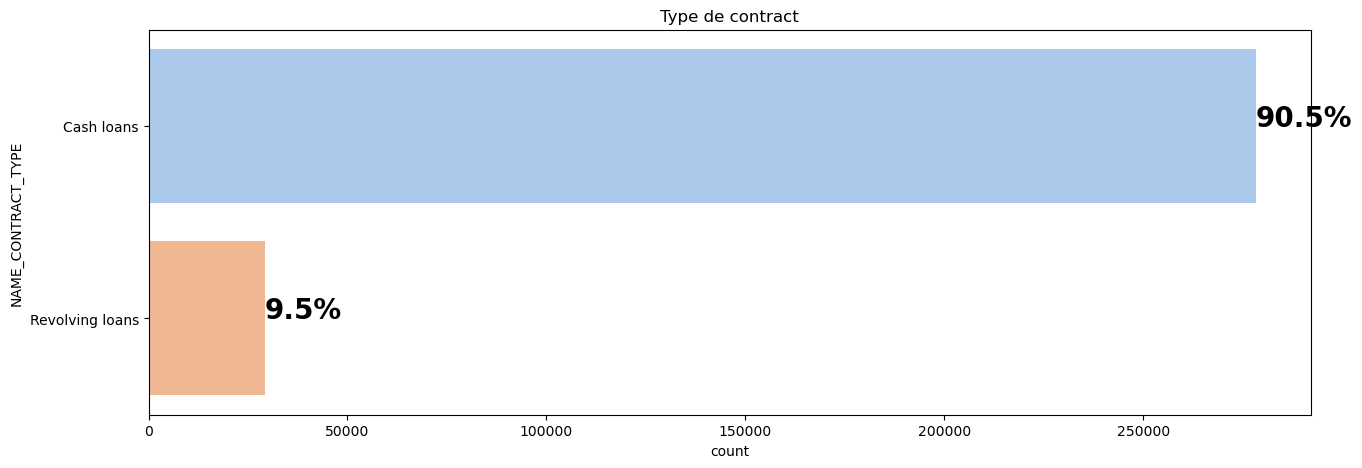

                                   -------------------------------------------------------


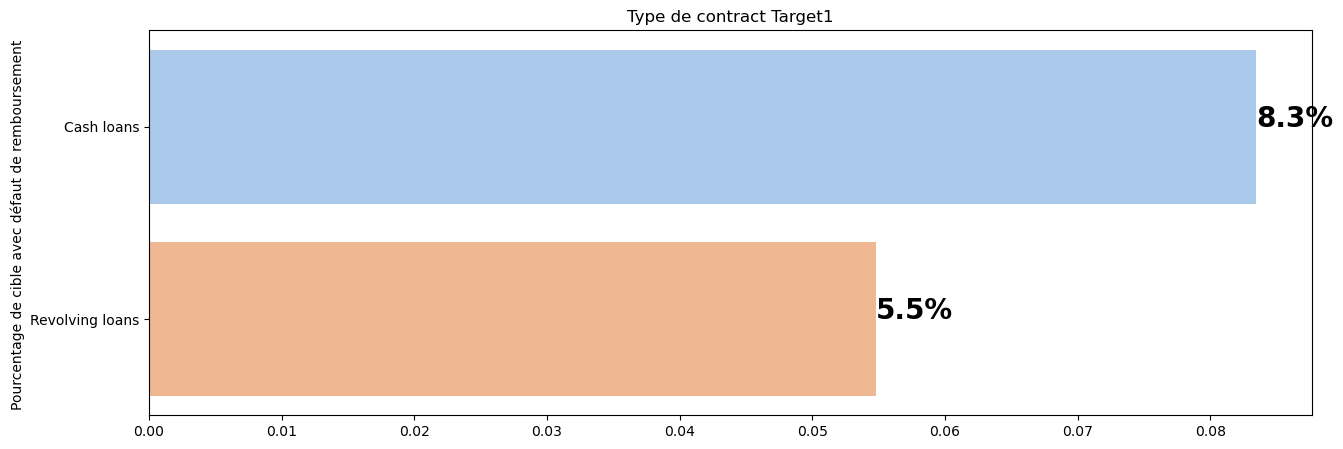

In [25]:
#NAME_CONTRACT_TYPE
plot_histogram(application_train, 'NAME_CONTRACT_TYPE',"Type de contract")
print("                                   -------------------------------------------------------")

#pour target=1
plot_target1(application_train, 'NAME_CONTRACT_TYPE',"Type de contract Target1")



Les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés.





<**CODE_GENDER**>

---
Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non retourné).



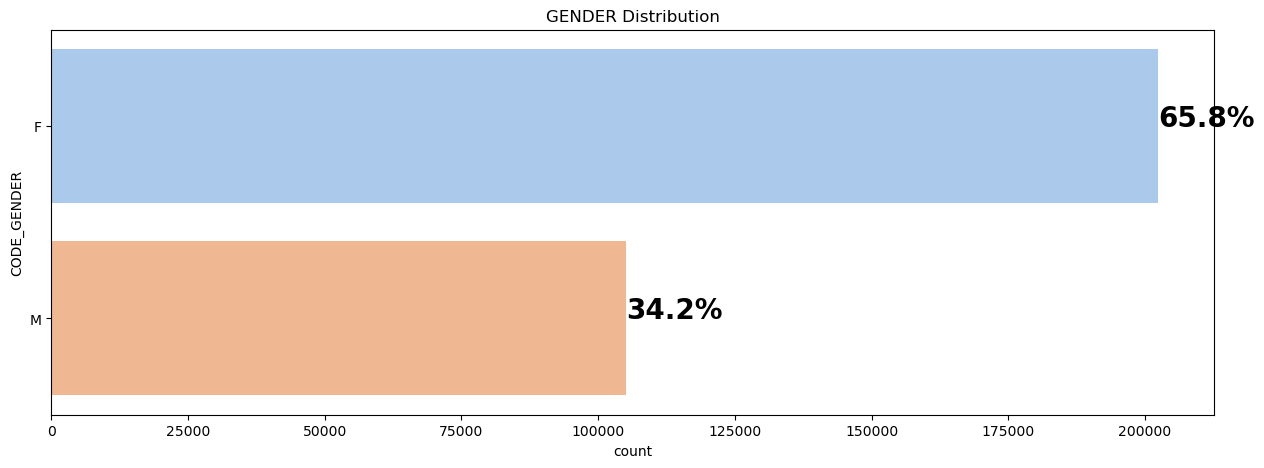

                                   -------------------------------------------------------


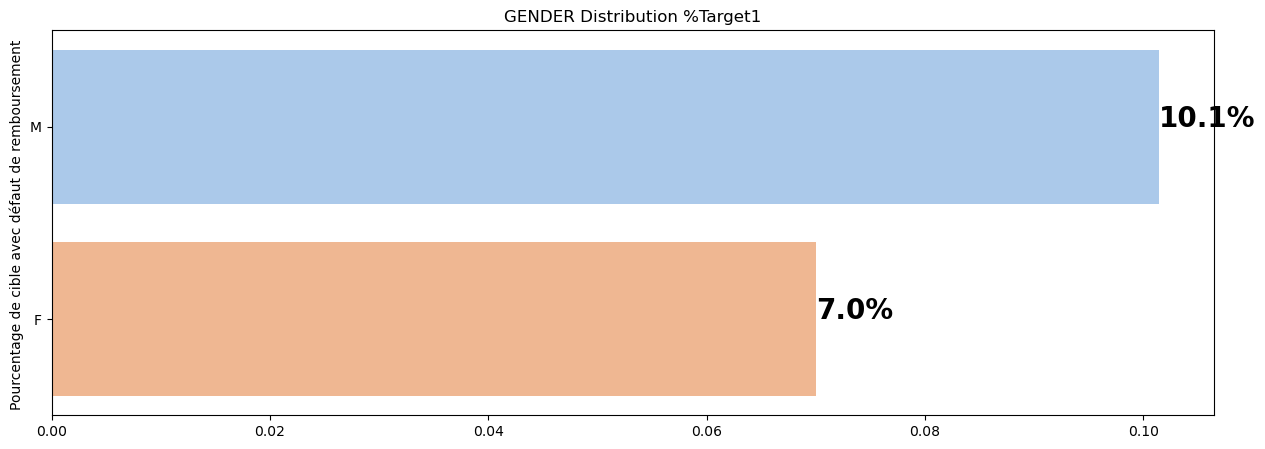

In [26]:
#CODE_GENDER
plot_histogram(application_train, 'CODE_GENDER',"GENDER Distribution")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'CODE_GENDER',"GENDER Distribution %Target1")



- Le nombre de clientes  est presque le double du nombre de clients .
- Pour les remboursements, les hommes ont plus de chances de ne pas rembourser leurs prêts (10%), par rapport aux femmes (7%).



### **FLAG_OWN_CAR**


---



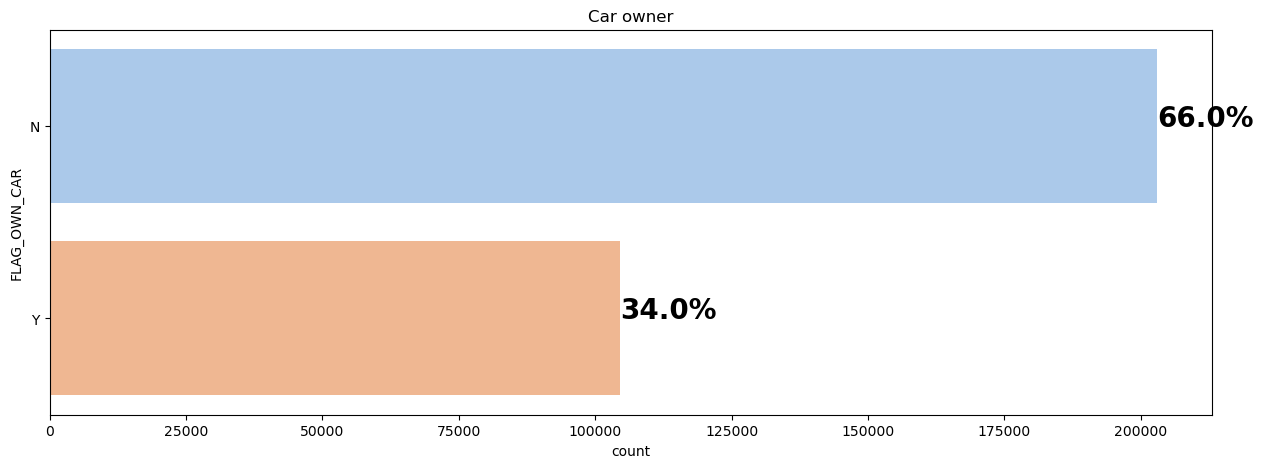

                                   -------------------------------------------------------


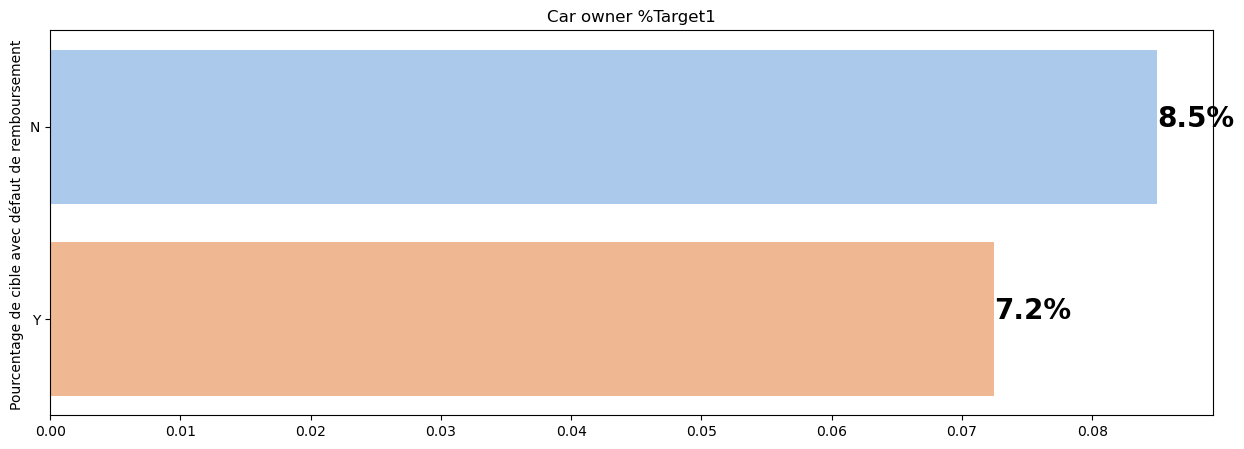

In [27]:
plot_histogram(application_train, 'FLAG_OWN_CAR',"Car owner")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'FLAG_OWN_CAR',"Car owner %Target1")


Les deux catégories (propriétaire ou non) ont des taux de non-remboursement quasi-égal d'environ 8%.



**NAME_FAMILY_STATUS**


---



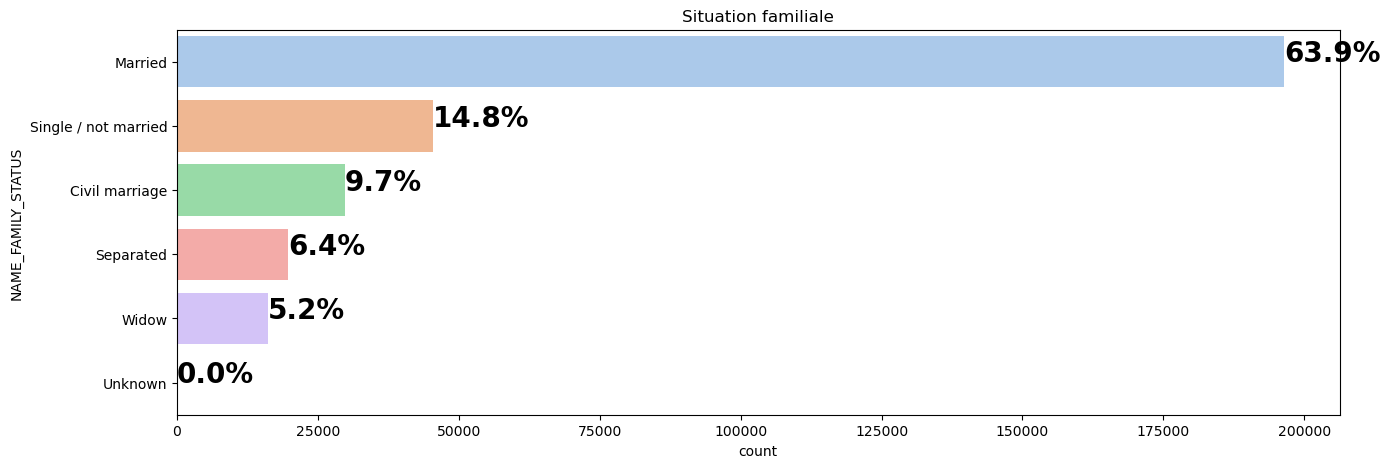

                                   -------------------------------------------------------


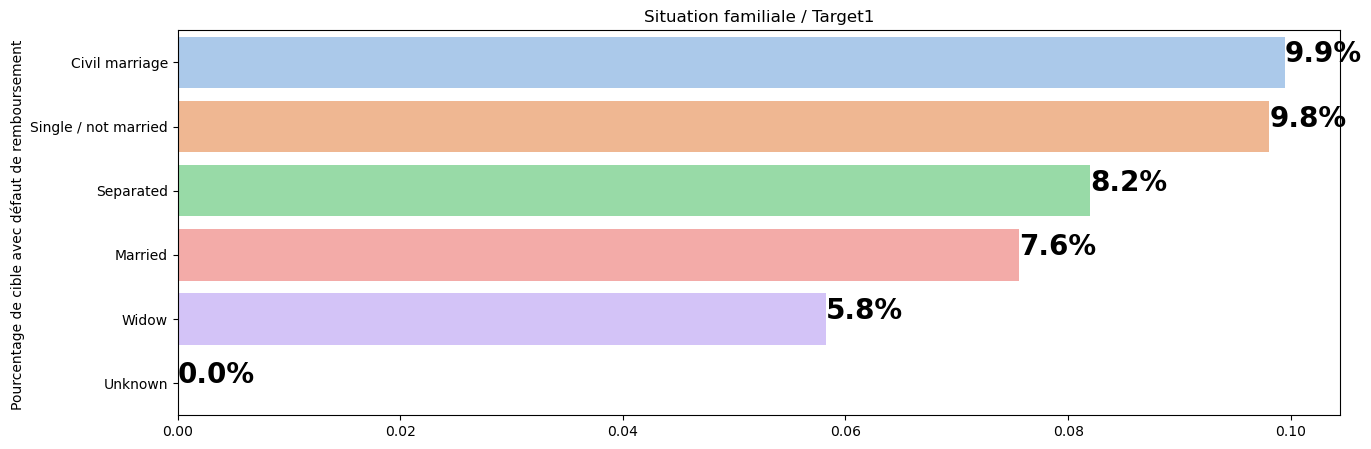

In [28]:
#NAME_FAMILY_STATUS
plot_histogram(application_train, 'NAME_FAMILY_STATUS',"Situation familiale")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'NAME_FAMILY_STATUS',"Situation familiale / Target1")


En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de unknown).




< **NAME_INCOME_TYPE** >

---



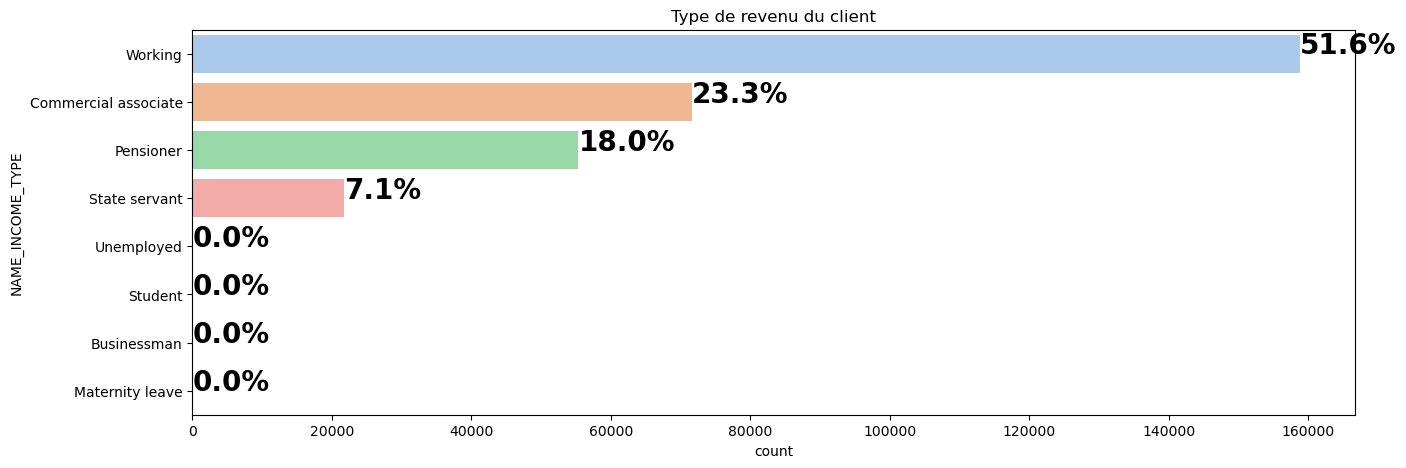

                                   -------------------------------------------------------


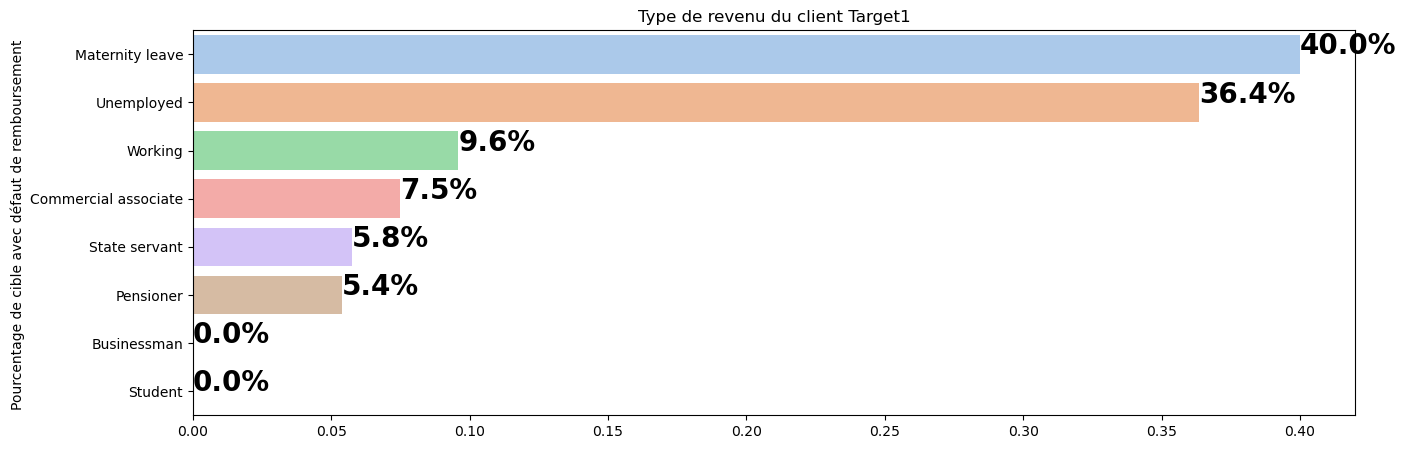

In [29]:
plot_histogram(application_train, 'NAME_INCOME_TYPE',"Type de revenu du client")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'NAME_INCOME_TYPE',"Type de revenu du client Target1")


La majorité des demandeurs de prêts sont des personnes ayant un revenu provenant du travail, suivi par des travailleurs indépendants, des retraités et des fonctionnaires.

Parmi les demandeurs ayant un congé de maternité, près de 40% ne remboursent pas leurs prêts, suivis par les chômeurs avec un taux de 37%. Les autres types de revenus ont un taux de non-remboursement inférieur à la moyenne de 10%.






<**OCCUPATION_TYPE**>

---



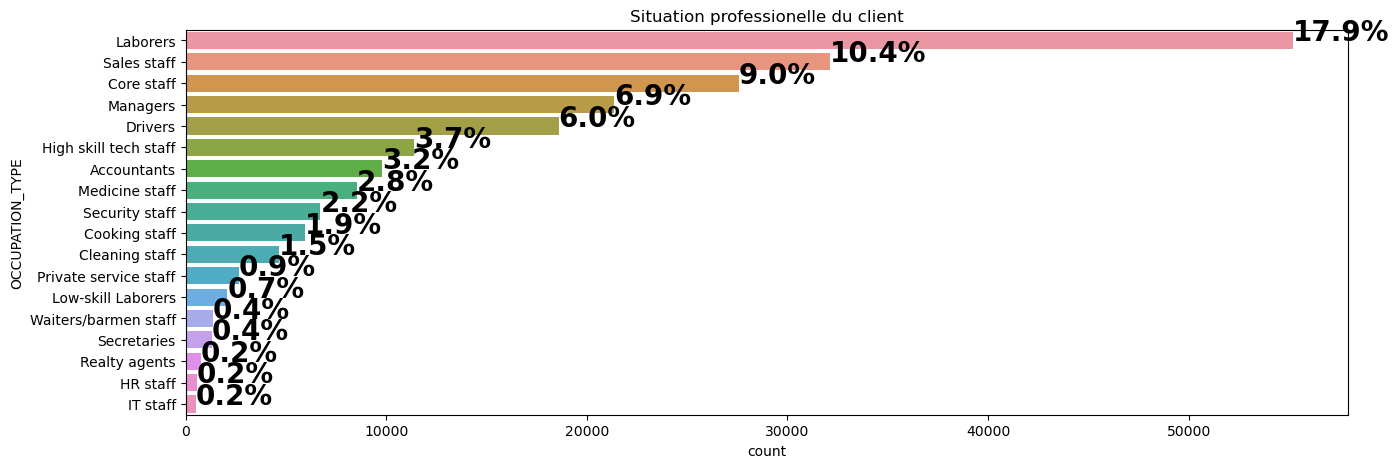

                                   -------------------------------------------------------


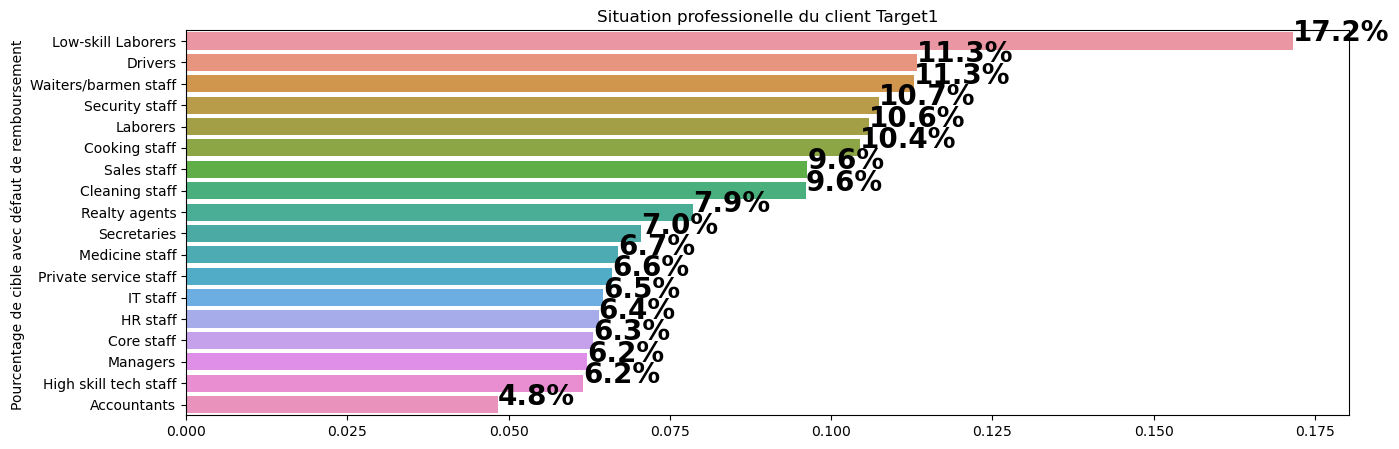

In [30]:
plot_histogram(application_train, 'OCCUPATION_TYPE',"Situation professionelle du client")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'OCCUPATION_TYPE',"Situation professionelle du client Target1")


Les ouvriers constituent la majorité des emprunteurs, suivis par les vendeurs/commerciaux. Le personnel informatique présente le montant de prêt le plus bas.

La catégorie avec le taux le plus élevé de défauts de paiement est celle des ouvriers peu qualifiés, dépassant les 17%. Elle est suivie par les chauffeurs, les serveurs/barmen, le personnel de sécurité, les ouvriers et le personnel de cuisine.






<**NAME_EDUCATION_TYPE**>


---




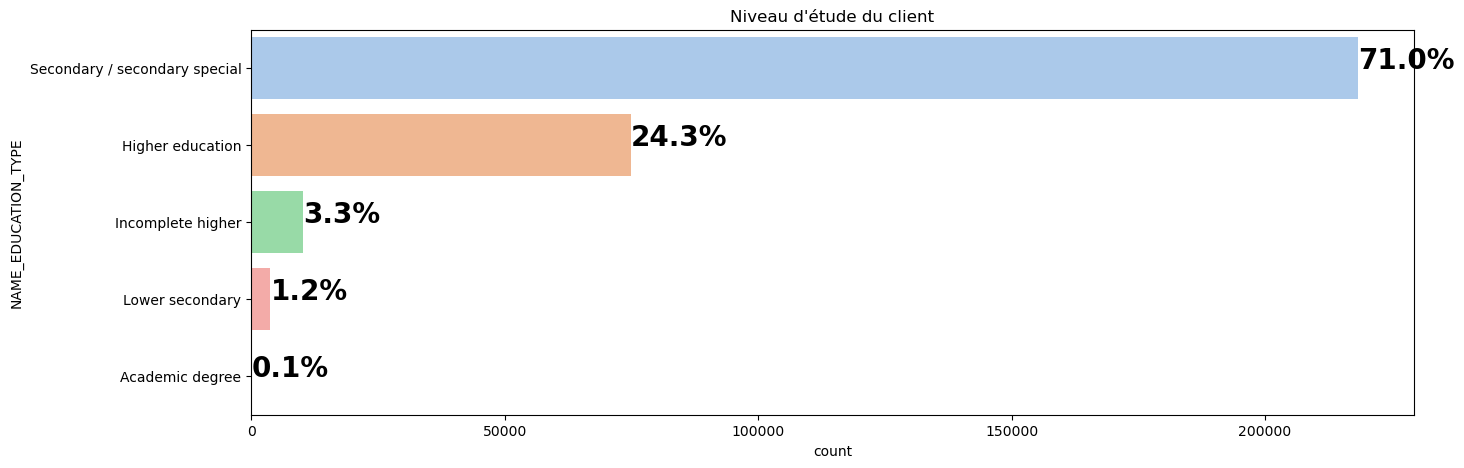

                                   -------------------------------------------------------


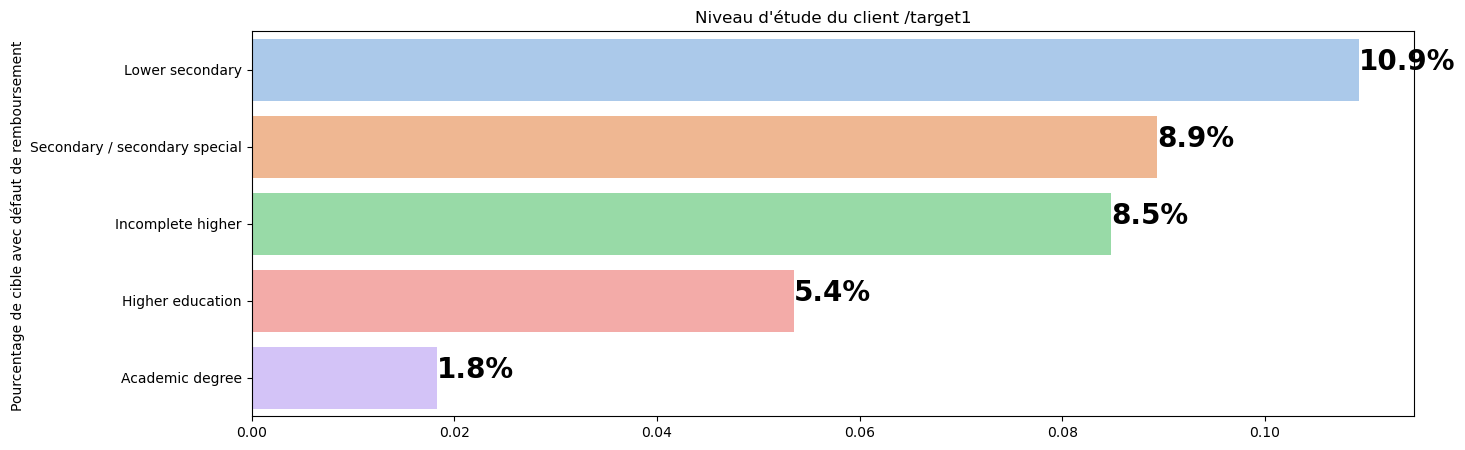

In [31]:
plot_histogram(application_train, 'NAME_EDUCATION_TYPE',"Niveau d'étude du client")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'NAME_EDUCATION_TYPE',"Niveau d'étude du client /target1")


La plupart des clients ont achevé leurs études secondaires, suivis par ceux ayant une éducation supérieure. Seuls un nombre très restreint d'emprunteurs possèdent un diplôme universitaire.

La catégorie des diplômés du premier cycle du secondaire, bien que peu fréquente, présente le taux le plus élevé de non-remboursement des prêts (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.






<**NAME_HOUSING_TYPE**>

---



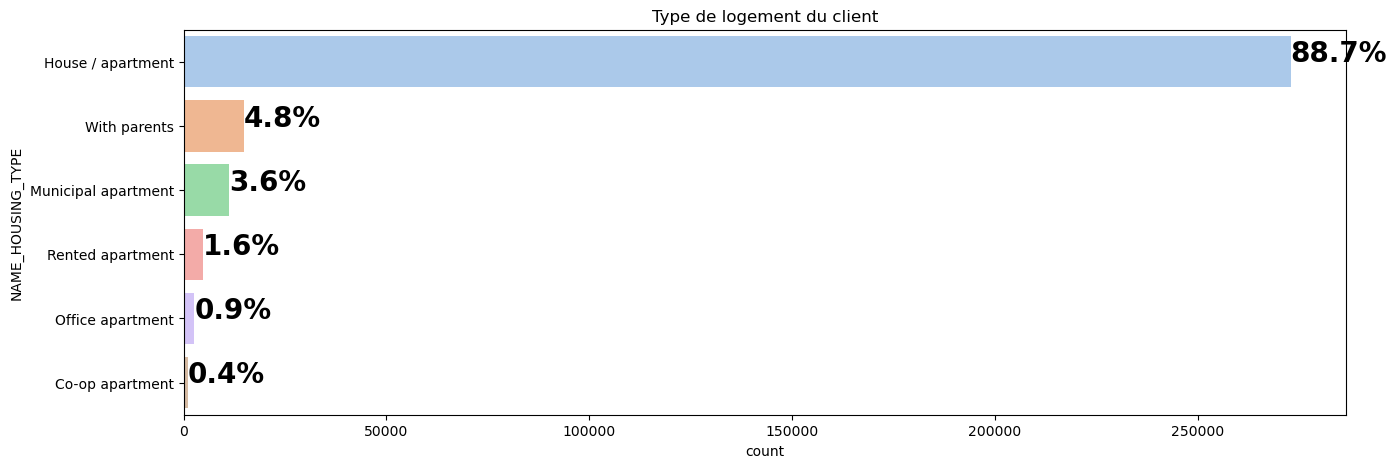

                                   -------------------------------------------------------


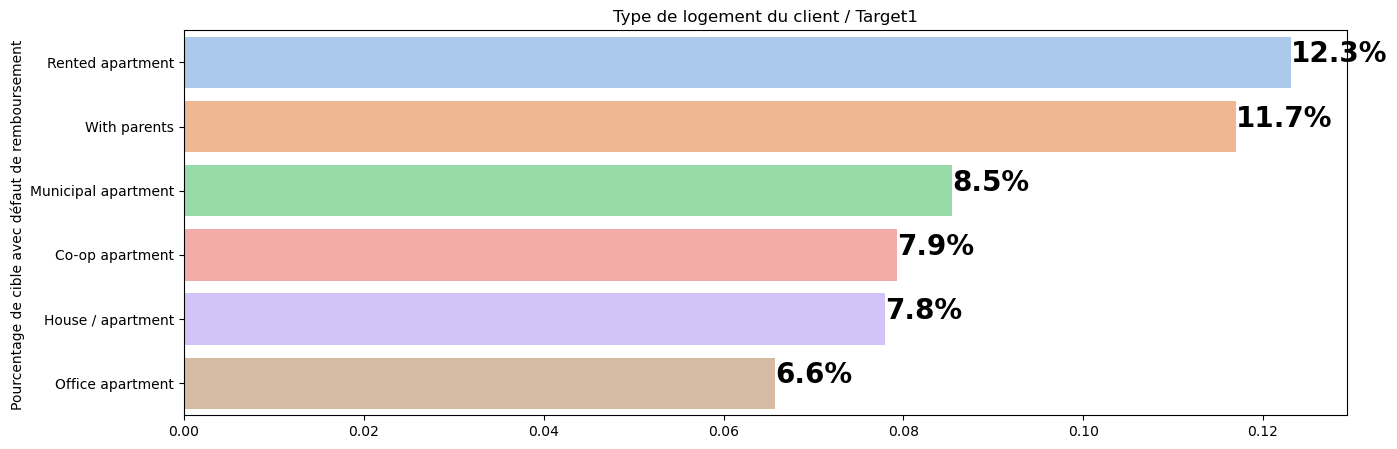

In [32]:

plot_histogram(application_train, 'NAME_HOUSING_TYPE',"Type de logement du client")
print("                                   -------------------------------------------------------")
plot_target1(application_train, 'NAME_HOUSING_TYPE',"Type de logement du client / Target1")


Plus de 250 000 demandeurs de crédit résident dans des maisons ou des appartements. Les catégories suivantes, qui représentent une proportion plus faible, incluent des individus vivant dans des situations de dépendance (chez leurs parents, etc.).

Dans ces catégories, les locataires d'appartements (qui ne sont pas propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, affichent un taux de non-remboursement supérieur à 10%.






### Les corrélations 
L'analyse peut se poursuivre par une étape de traitement des corrélations entre les différentes features et la variable cible. L'objectif est de calculer le coefficient de corrélation de Pearson entre chaque variable et la variable cible. Cette étape permet de mieux comprendre les relations potentielles entre les variables.

In [33]:
#Affichage des correlations
print('Les corrélations les plus +:\n', application_train.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Les coorélations les plus - :\n', application_train.corr()['TARGET'].sort_values().head(15))


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\3246664519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Les corrélations les plus +:\n', application_train.corr()['TARGET'].sort_values().tail(15))


Les corrélations les plus +:
 DEF_30_CNT_SOCIAL_CIRCLE       0.0323
LIVE_CITY_NOT_WORK_CITY        0.0325
OWN_CAR_AGE                    0.0376
DAYS_REGISTRATION              0.0420
FLAG_DOCUMENT_3                0.0443
REG_CITY_NOT_LIVE_CITY         0.0444
FLAG_EMP_PHONE                 0.0460
REG_CITY_NOT_WORK_CITY         0.0510
DAYS_ID_PUBLISH                0.0515
DAYS_LAST_PHONE_CHANGE         0.0552
REGION_RATING_CLIENT           0.0589
REGION_RATING_CLIENT_W_CITY    0.0609
DAYS_EMPLOYED                  0.0750
DAYS_BIRTH                     0.0782
TARGET                         1.0000
Name: TARGET, dtype: float64
--------------------------


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\3246664519.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Les coorélations les plus - :\n', application_train.corr()['TARGET'].sort_values().head(15))


Les coorélations les plus - :
 EXT_SOURCE_3                 -0.1789
EXT_SOURCE_2                 -0.1605
EXT_SOURCE_1                 -0.1553
DAYS_EMPLOYED_OUTLIERS       -0.0460
FLOORSMAX_AVG                -0.0440
FLOORSMAX_MEDI               -0.0438
FLOORSMAX_MODE               -0.0432
AMT_GOODS_PRICE              -0.0396
REGION_POPULATION_RELATIVE   -0.0372
ELEVATORS_AVG                -0.0342
ELEVATORS_MEDI               -0.0339
FLOORSMIN_AVG                -0.0336
FLOORSMIN_MEDI               -0.0334
LIVINGAREA_AVG               -0.0330
LIVINGAREA_MEDI              -0.0327
Name: TARGET, dtype: float64


La variable 'DAYS_BIRTH' présente la corrélation la plus forte. Toutefois, afin de faciliter la compréhension et de retrouver la logique mentionnée précédemment, il est possible de traiter les jours exprimés en valeurs négatives en utilisant leur valeur absolue. Ainsi, le coefficient de corrélation de Pearson sera négatif, ce qui indique que les clients plus âgés ont moins de chances de faire défaut dans le remboursement de leur crédit (ce qui peut sembler logique).

In [34]:
#Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])


-0.07824216003619362

En ce qui concerne la distribution des âges, elle peut être utilisée pour vérifier la présence d'éventuels valeurs aberrantes (outliers) après avoir effectué le traitement préalable sur les valeurs négatives. Afin d'illustrer l'impact de l'âge sur la variable cible, nous pouvons créer un graphique (KDE) où les couleurs représentent les valeurs de la TARGET, à savoir 0 et 1.






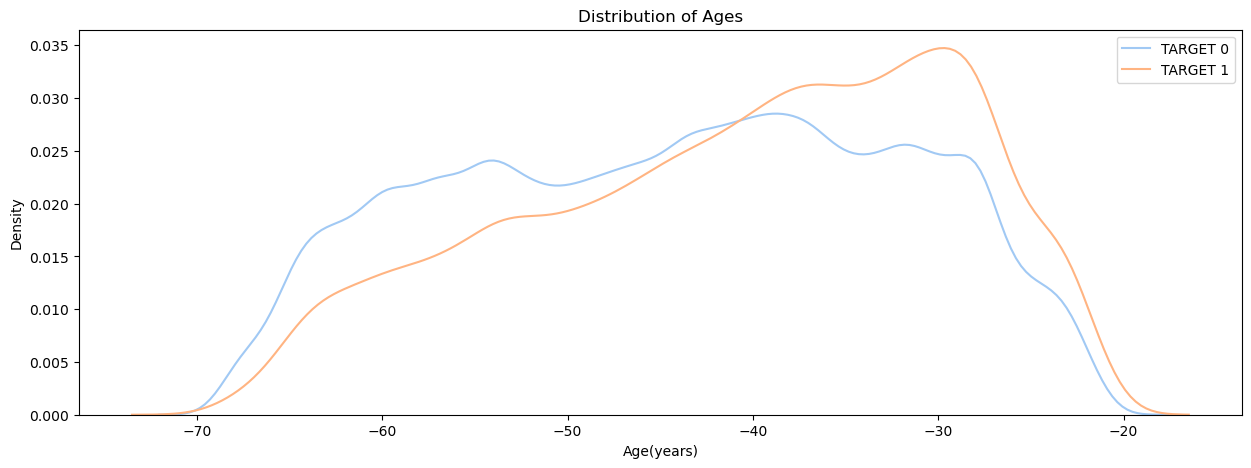

In [35]:
plt.figure(figsize = (15, 5))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Distribution of Ages')
show()


La courbe de la variable cible TARGET 1 montre une tendance à s'incliner vers les tranches d'âge les plus jeunes de la plage. Bien que la corrélation ne soit pas significative (coefficient de corrélation de Pearson de -0,07), cette variable peut être utile dans un modèle d'apprentissage car elle influence la variable cible.






Les trois variables (EXT_SOURCE) affichent les corrélations négatives les plus fortes avec la variable cible. Selon la documentation, ces caractéristiques représentent un "score normalisé à partir d'une source de données externe". Il est difficile de comprendre précisément leur signification, mais nous pouvons émettre l'hypothèse d'une cote de crédit cumulative établie à l'aide de différentes sources de données.


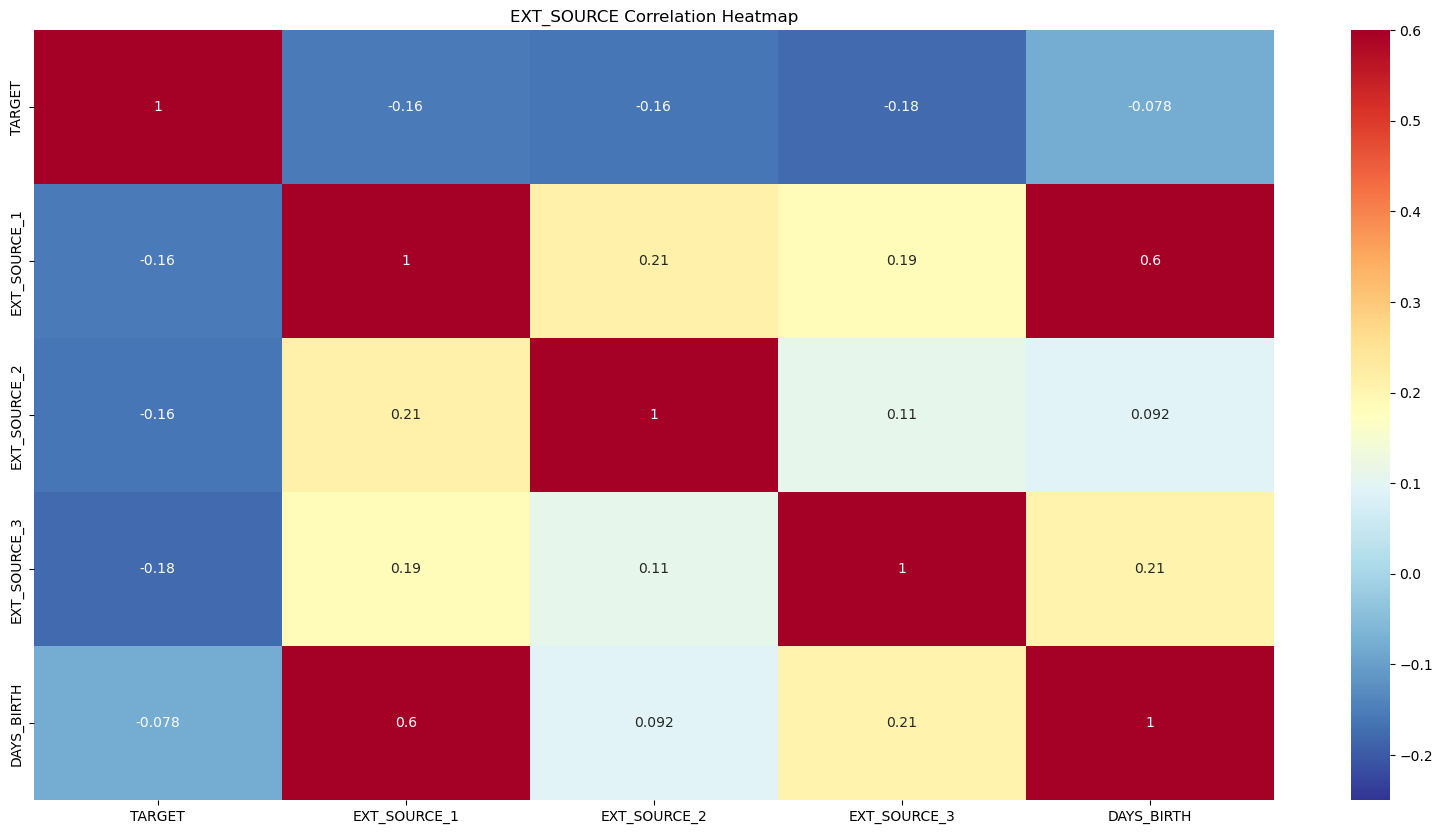

In [36]:
#Heatmap des correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
show()

### Bilan:
---
Les sources externes présentent une corrélation négative avec la variable cible, bien que les coefficients de corrélation soient très faibles. Malgré cela, il est possible de supposer que si la valeur de ces sources externes augmente, le client a plus de chances de pouvoir rembourser le crédit. 
De plus,  'DAYS_BIRTH' est corrélée avec 'EXT_SOURCE_1', ce qui suggère que l'âge du client pourrait être l'un des facteurs influençant ce score.









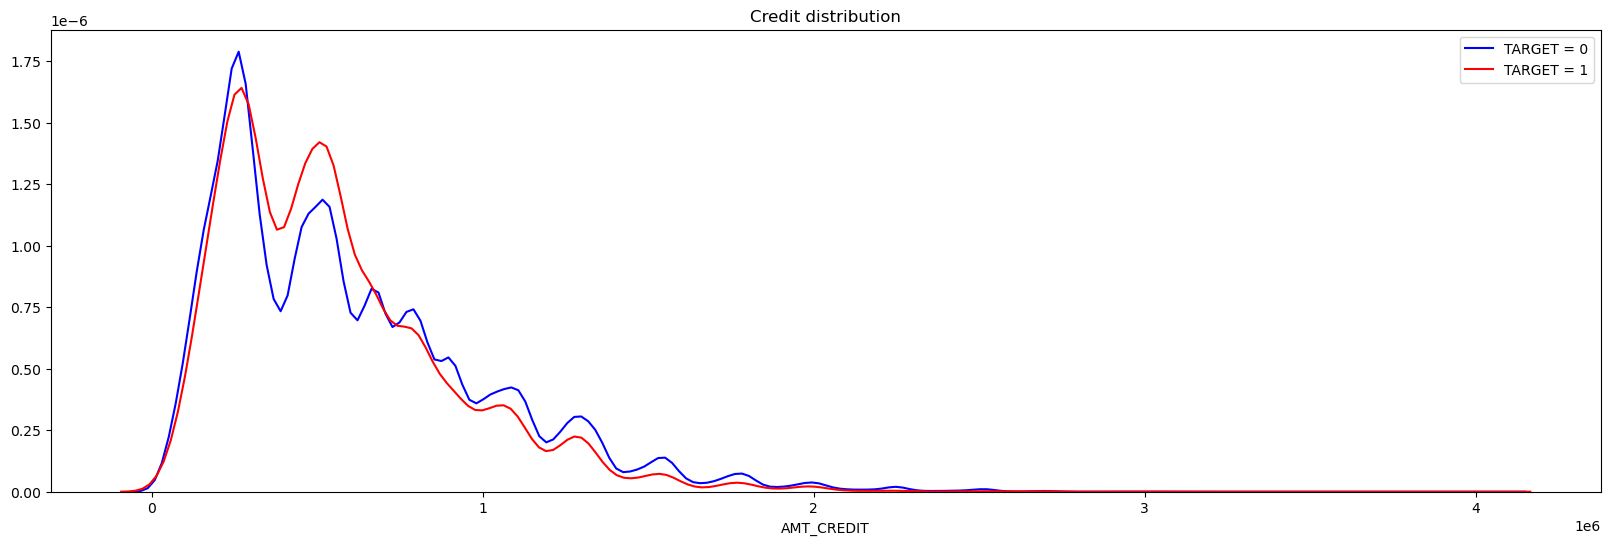

                                   -------------------------------------------------------


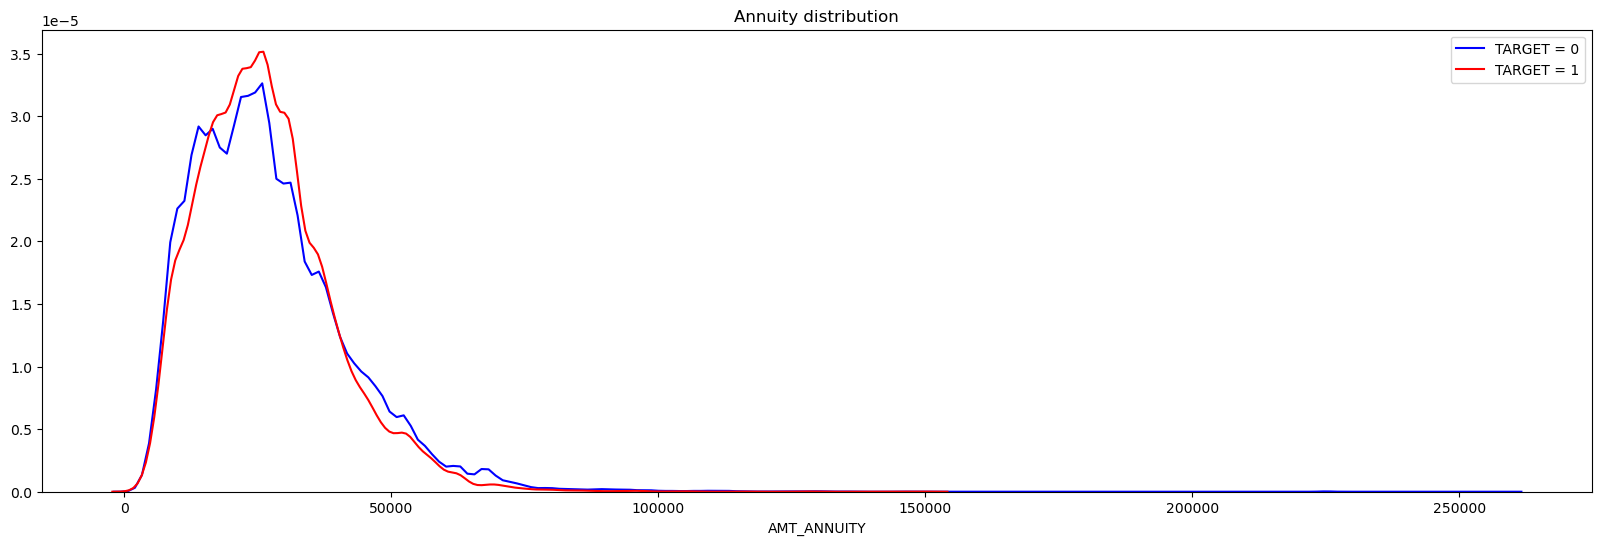

                                   -------------------------------------------------------


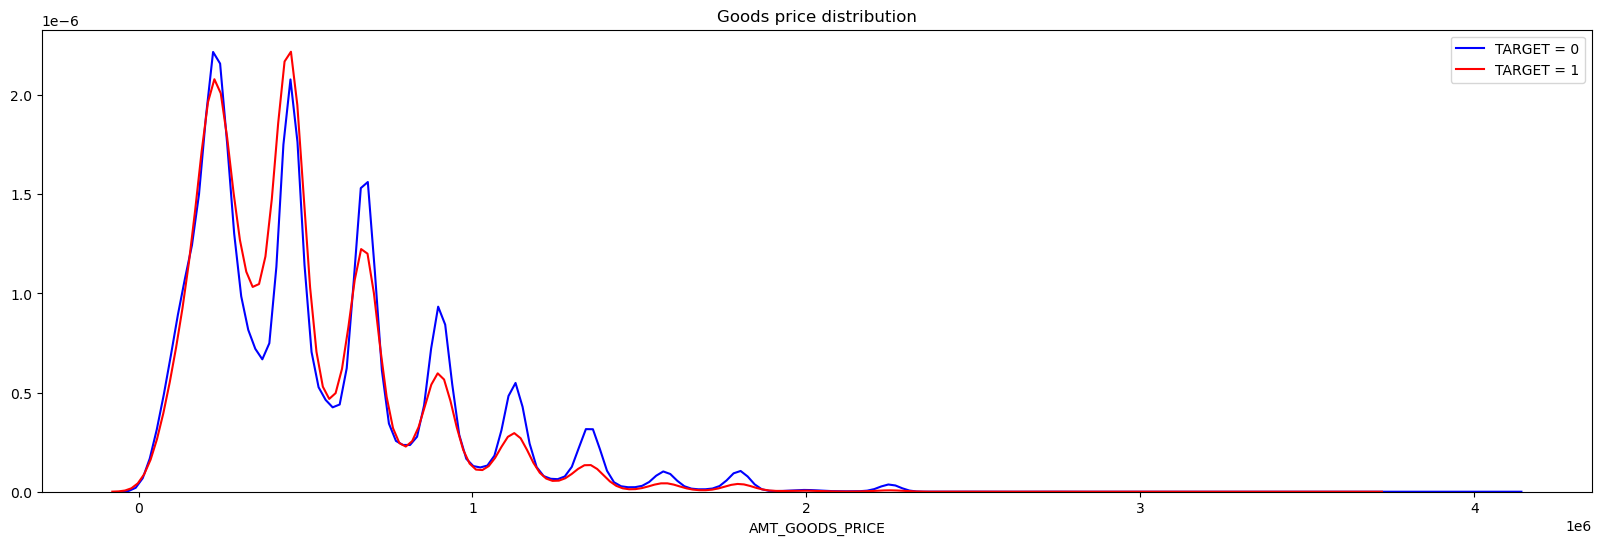

                                   -------------------------------------------------------


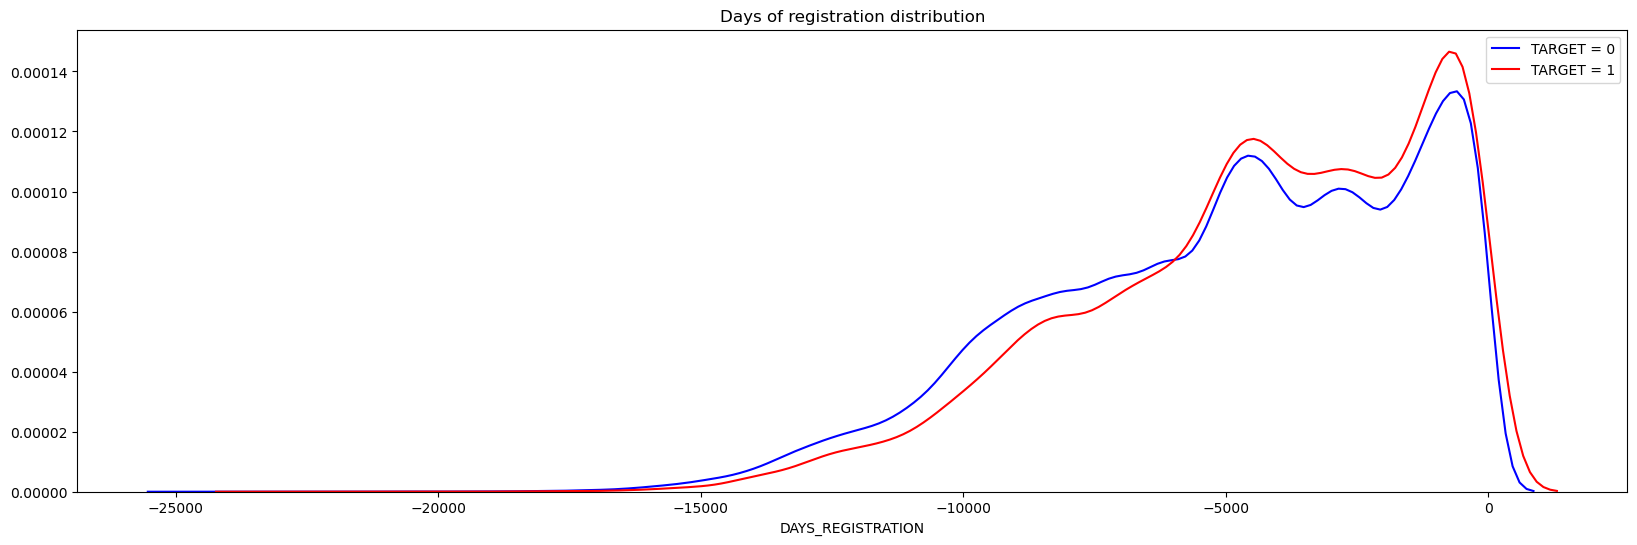

                                   -------------------------------------------------------


In [37]:
plot_kde('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_kde('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_kde('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_kde('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   -------------------------------------------------------")




---


## 2- Analyse exploratoire de bureau.csv

---



Le fichier en question contient l'historique de tous les prêts précédents des clients, fournis par d'autres institutions financières et déclarés au Bureau de crédit (pour les clients ayant un prêt dans l'échantillon). Pour chaque prêt dans l'échantillon, il existe autant de lignes que de crédits que le client avait enregistrés auprès du Bureau de crédit avant la date de la demande. La clé "SK_ID_CURR" est utilisée pour relier les données de l'application_train | test aux données du bureau.

Il est nécessaire de fusionner les données de "application_train" avec celles du "bureau" afin d'extraire la part où TARGET == 1.






In [38]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')


<**CREDIT_ACTIVE**>

---



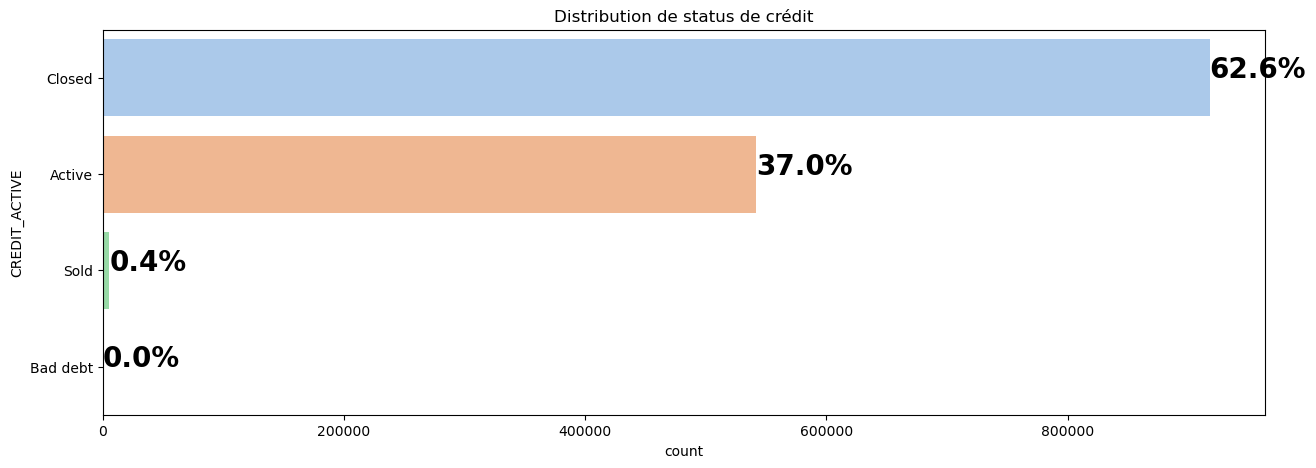

                                   -------------------------------------------------------


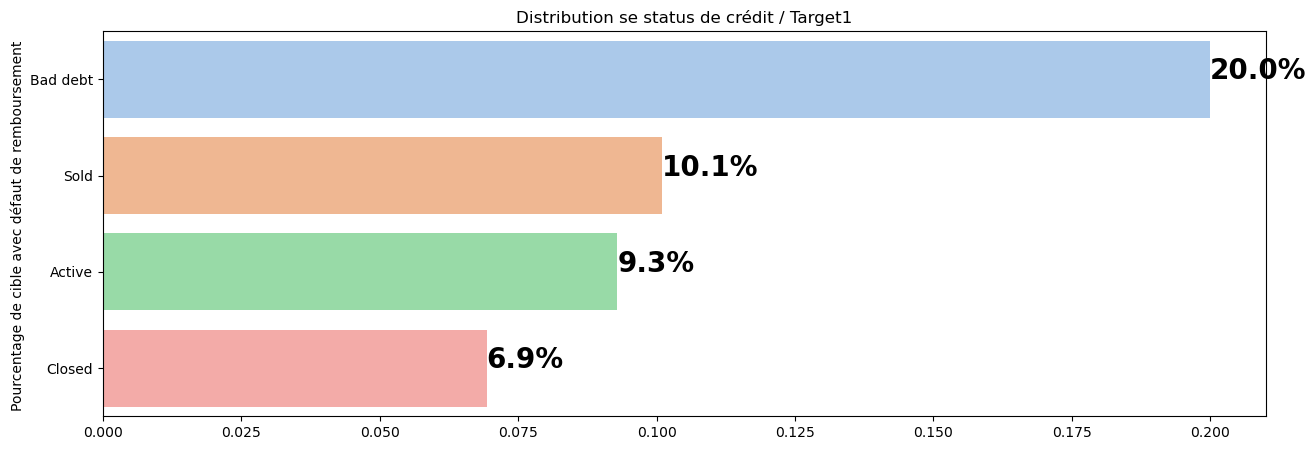

In [39]:

plot_histogram(application_bureau_train, 'CREDIT_ACTIVE',"Distribution de status de crédit")
print("                                   -------------------------------------------------------")
plot_target1(application_bureau_train, 'CREDIT_ACTIVE',"Distribution se status de crédit / Target1")


<**CREDIT_CURRENCY**>

---




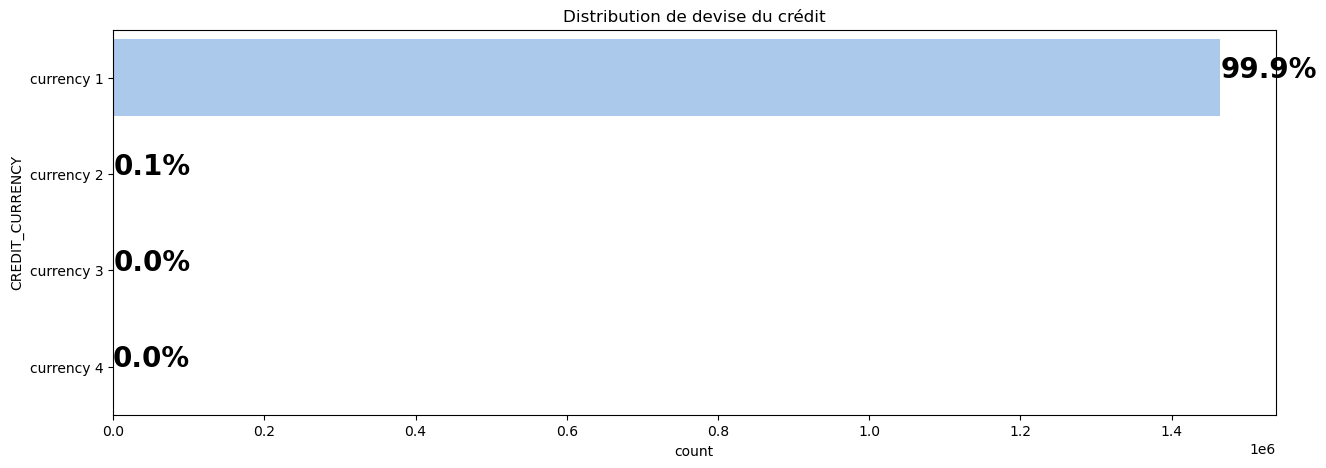

                                   -------------------------------------------------------


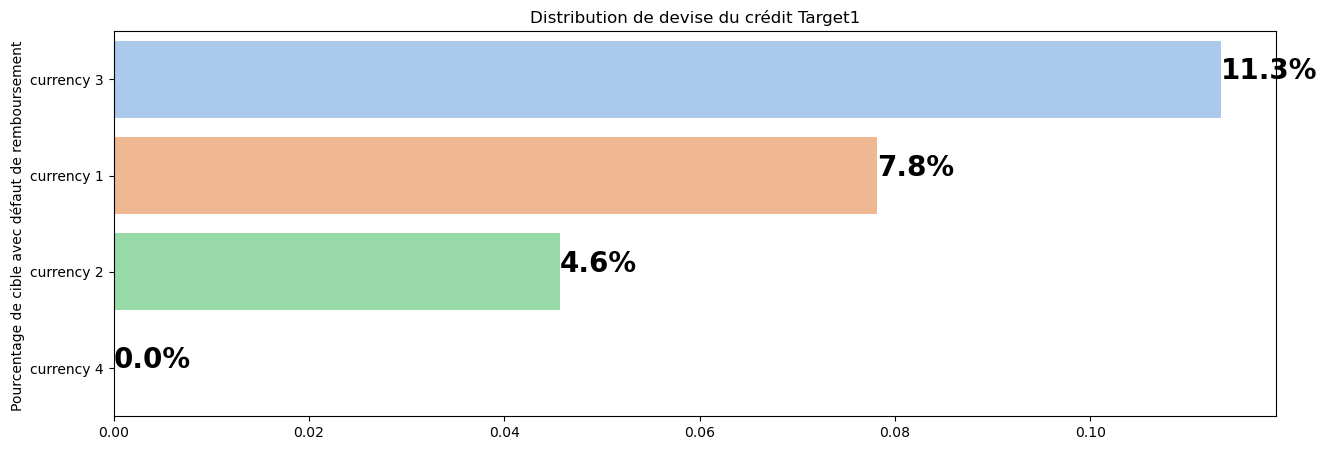

In [40]:
plot_histogram(application_bureau_train, 'CREDIT_CURRENCY',"Distribution de devise du crédit")
print("                                   -------------------------------------------------------")
plot_target1(application_bureau_train, 'CREDIT_CURRENCY',"Distribution de devise du crédit Target1")

<**CREDIT_TYPE**>

---




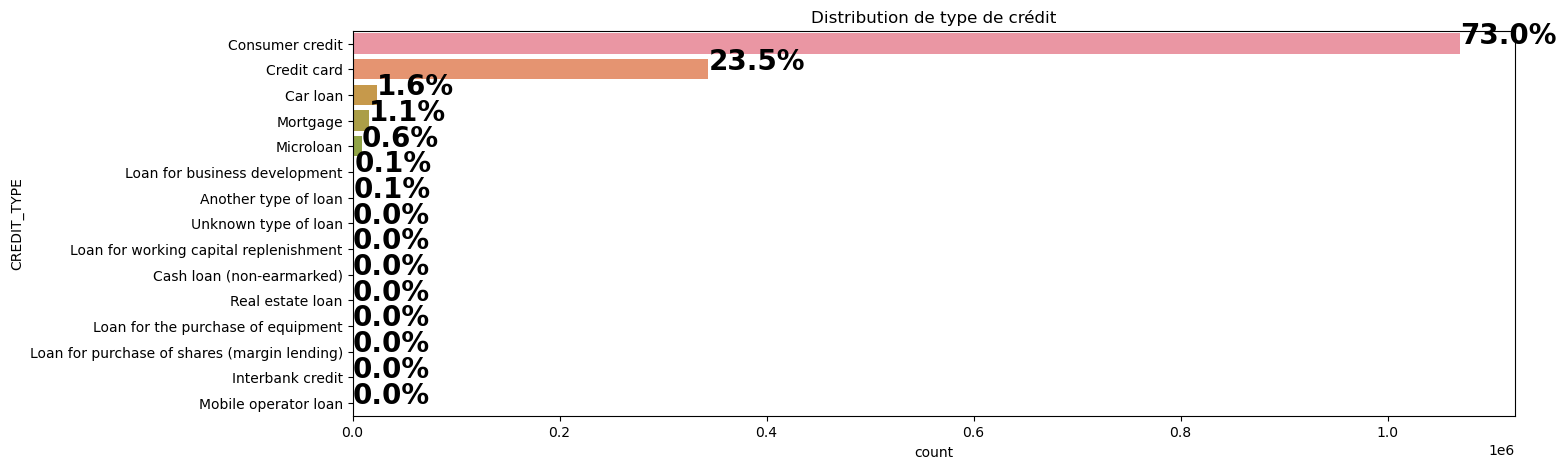

                                   -------------------------------------------------------


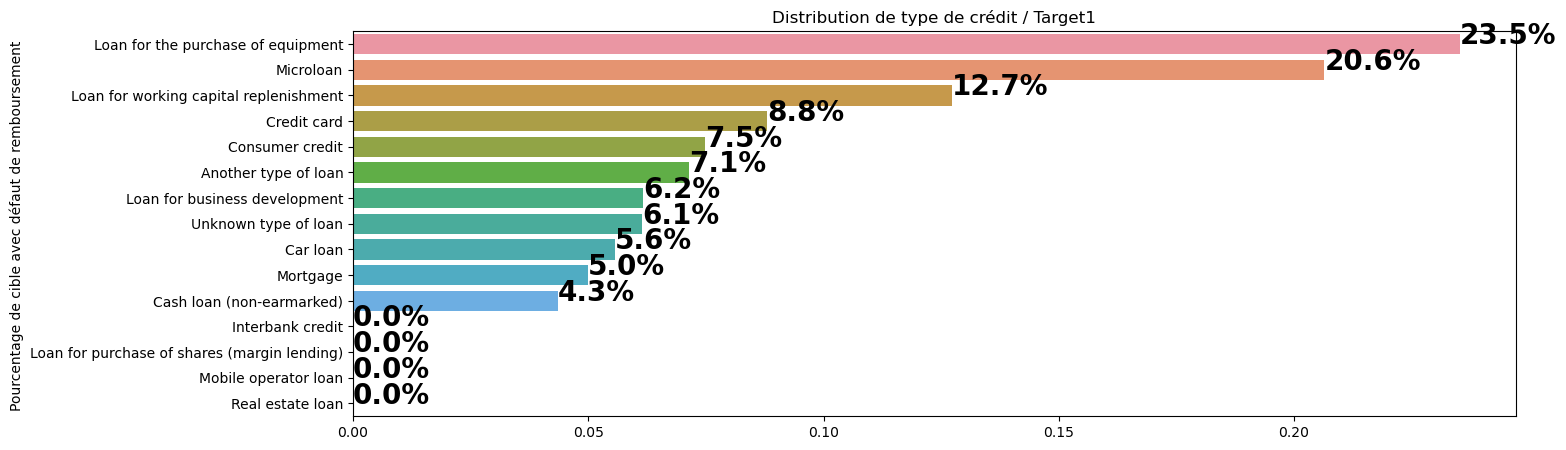

In [41]:
plot_histogram(application_bureau_train, 'CREDIT_TYPE',"Distribution de type de crédit")
print("                                   -------------------------------------------------------")
plot_target1(application_bureau_train, 'CREDIT_TYPE',"Distribution de type de crédit / Target1")



---


## 3- Analyse exploratoire de  previous_application.csv

---



Le fichier "previous_application" contient des informations sur toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans l'échantillon. Chaque demande précédente liée aux prêts dans notre ensemble de données est représentée par une ligne distincte. La clé "SK_ID_CURR" est utilisée pour relier les données de l'application_train | test aux données de "previous_application".

Il est nécessaire de fusionner les données de "application_train" avec celles de "previous_application" afin d'extraire la partie où TARGET == 1.






In [42]:
application_prev_train = application_train.merge(previous_application, 
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')


<**NAME_CONTRACT_TYPE_y**>

---




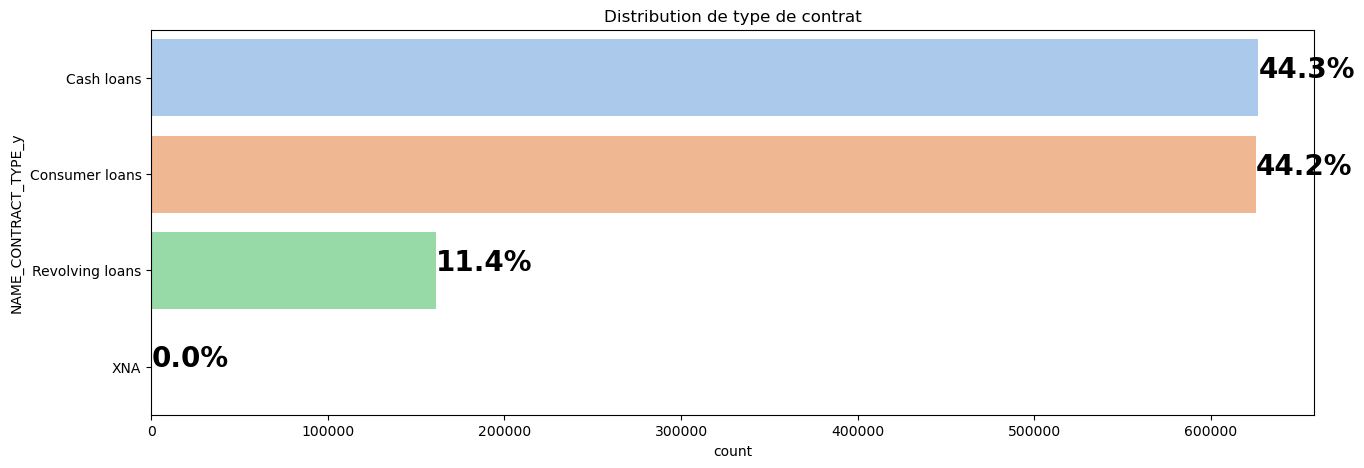

                                   -------------------------------------------------------


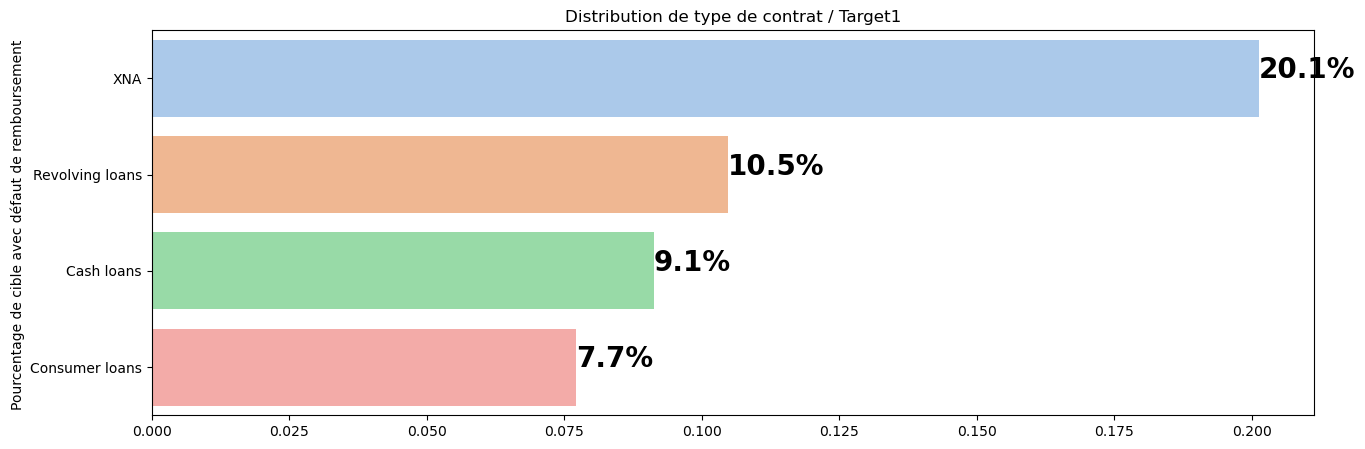

In [43]:
plot_histogram(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Distribution de type de contrat")
print("                                   -------------------------------------------------------")
plot_target1(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Distribution de type de contrat / Target1")


**NAME_CONTRACT_STATUS**

---




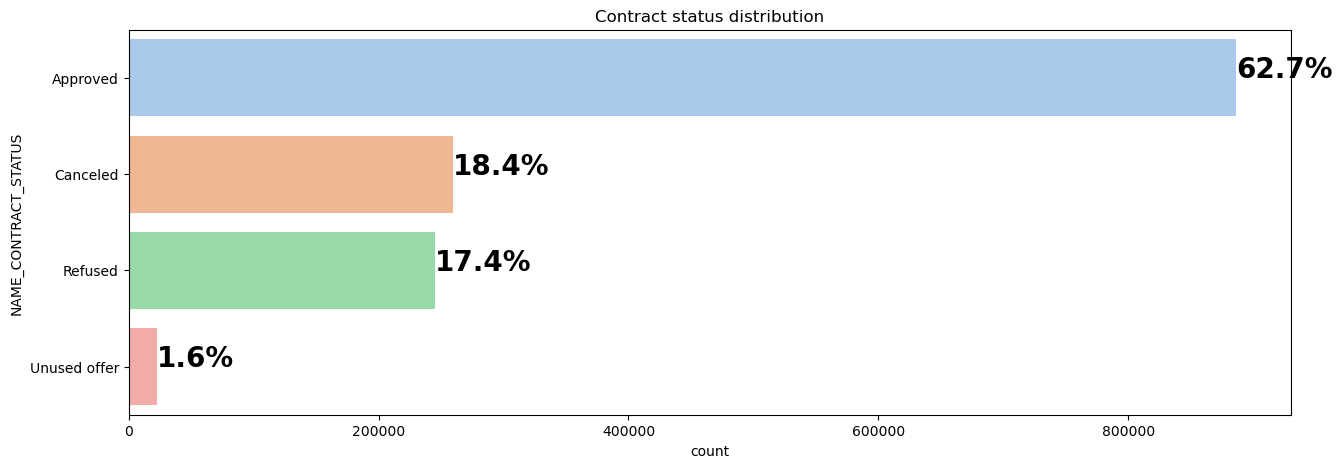

                                   -------------------------------------------------------


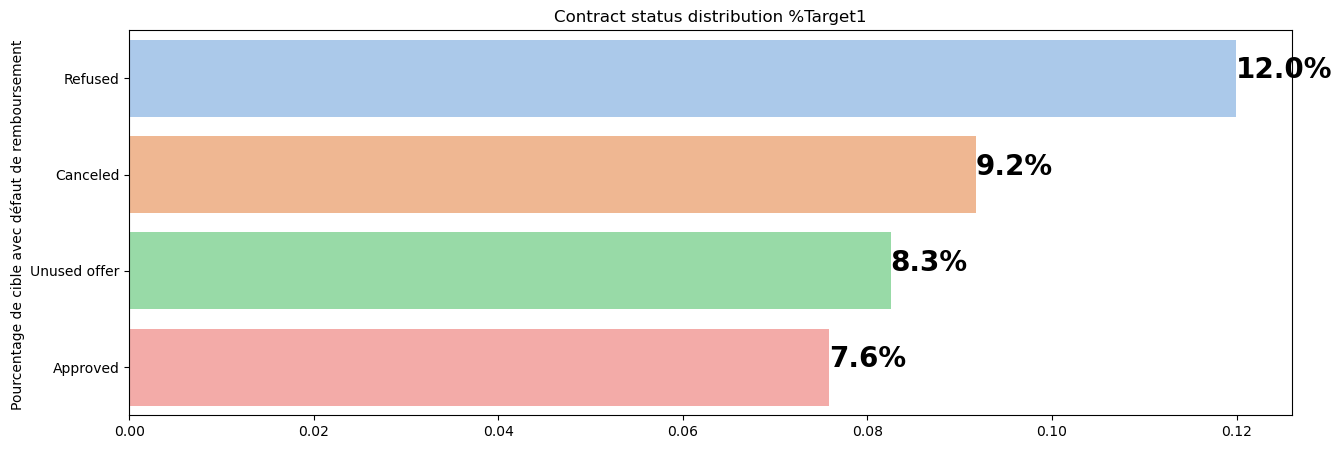

In [44]:
plot_histogram(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution")
print("                                   -------------------------------------------------------")
plot_target1(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution %Target1")



<**NAME_PAYMENT_TYPE**>

---



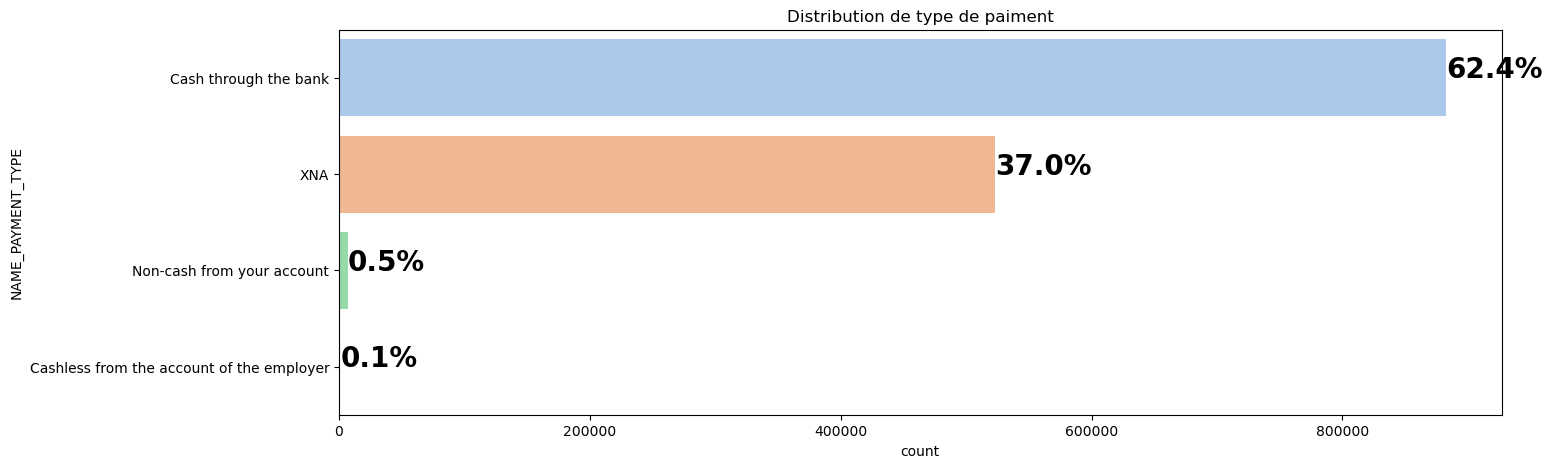

                                   -------------------------------------------------------


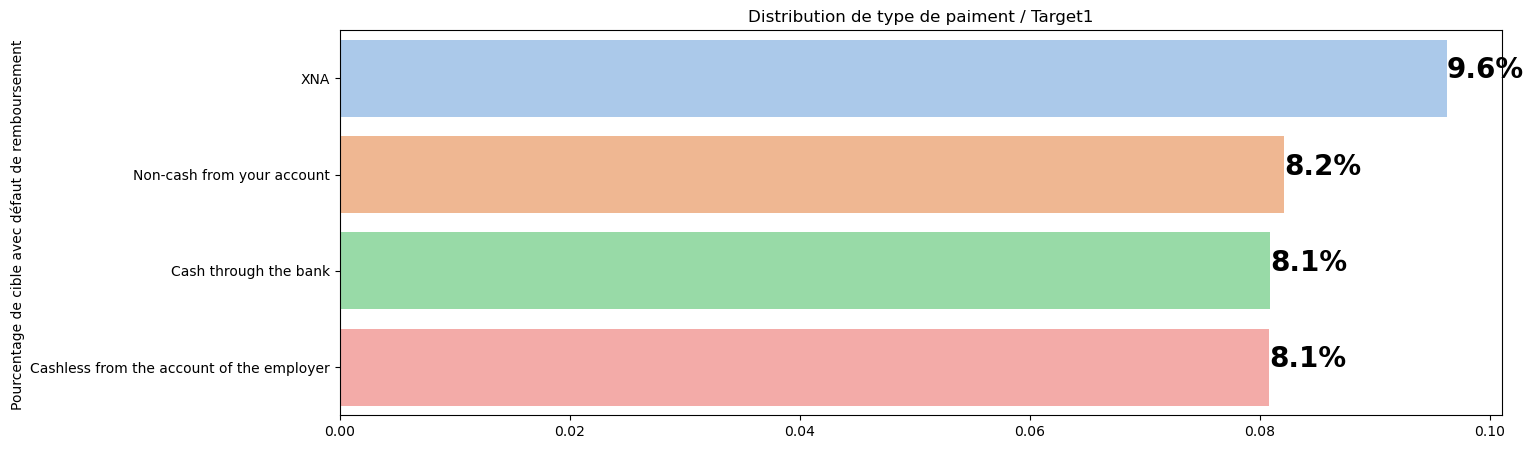

In [45]:
plot_histogram(application_prev_train, 'NAME_PAYMENT_TYPE',"Distribution de type de paiment")
print("                                   -------------------------------------------------------")
plot_target1(application_prev_train, 'NAME_PAYMENT_TYPE',"Distribution de type de paiment / Target1")


Le mode de paiement le plus courant est le paiement en espèces via la banque. Cependant, en cas de défaut de remboursement (Target 1), aucun type de paiement ne se distingue, car les différents types de paiement sont quasi égaux.






<**NAME_CLIENT_TYPE**>

---




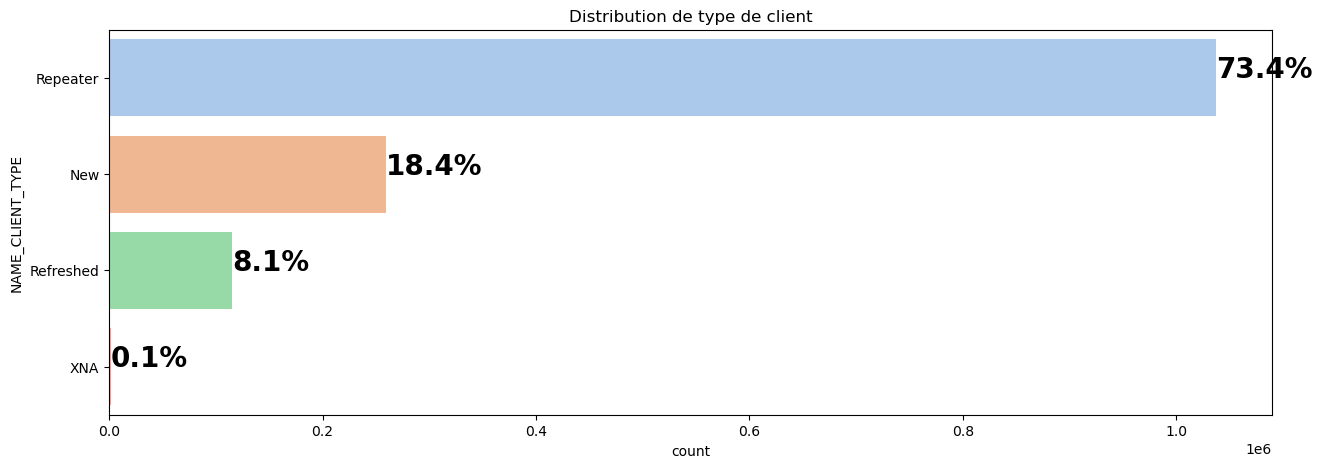

                                   -------------------------------------------------------


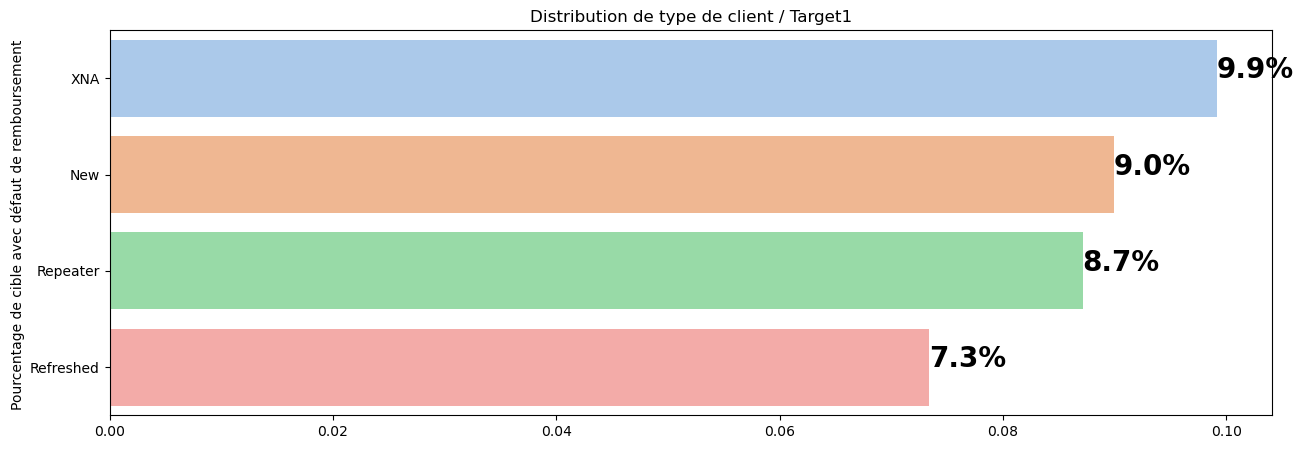

In [46]:
plot_histogram(application_prev_train, 'NAME_CLIENT_TYPE',"Distribution de type de client")
print("                                   -------------------------------------------------------")
plot_target1(application_prev_train, 'NAME_CLIENT_TYPE',"Distribution de type de client / Target1")


## Fusion des datasets

Il est essentiel de mener une réflexion approfondie et de réaliser une étape d'agrégation des données. En effet, des informations complémentaires provenant de fichiers auxiliaires peuvent avoir un impact significatif sur nos modèles. Voyons comment traiter l'ensemble des jeux de données de manière adéquate...






In [47]:
#Create a simple dataset with the train / test merge app
data = application_train.append(application_test)


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\2919701323.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = application_train.append(application_test)


Les deux jeux de données présentent exactement le même format, à l'exception d'une seule différence : la variable TARGET est disponible dans le jeu de données d'entraînement (train).






In [48]:
print('Train:' + str(application_train.shape))
print('Test:' + str(application_test.shape))
print('Data:' + str(data.shape))


Train:(307507, 123)
Test:(48744, 122)
Data:(356251, 123)


In [49]:
#vérifions
data.TARGET.isna().sum()


48744

En utilisant le fichier bureau.csv, il est possible de recueillir des informations sur l'historique des précédents crédits enregistrés par les clients. Par conséquent, il peut être bénéfique d'enrichir l'échantillon de données en incorporant ce type d'informations.







**bureau.csv**

In [50]:
display(bureau.head())
display(bureau.shape)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


(1716428, 17)

En effectuant le calcul du nombre total de crédits précédemment contractés par chaque client, nous pouvons enrichir davantage l'échantillon de travail avec ce type d'information.






In [51]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()


,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [52]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape
del previous_loan_counts
gc.collect()

35050

### data avec**bureau_balance : bureau_balance.csv**
---




In [53]:
display(bureau_balance.head())
display(bureau_balance.shape)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


(27299925, 3)

In [54]:
#Monthly average balances of previous credits in Credit Bureau.
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\2927067158.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns =


,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [55]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)
del bureau_bal_mean
gc.collect()

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

3365

In [56]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\1418439250.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')


(305811, 14)

In [57]:
#Merge all this features with our data sample
data = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
data.shape



(356251, 137)

In [58]:
del bureau_mean
gc.collect()

0

**previous_application**

---
Vérification des valeurs de 'SK_ID_CURR' entre data et previous_application…




In [59]:
display(previous_application.head())
display(previous_application.shape)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 37)

In [60]:
#Check 
len(previous_application.SK_ID_CURR.isin(data.SK_ID_CURR)) == len(previous_application)


True

Comme indiqué précédemment, nous allons commencer par quantifier le nombre de demandes précédentes de crédit immobilier effectuées par les clients, puis nous ajouterons ces données à l'échantillon.






In [61]:
#Number of previous applications of the clients to Home Credit
previous_application_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()


,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [62]:
#Merge this new column in our data sample
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')
data.shape
del previous_application_counts
gc.collect()

0



---


### avec credit_card_balance

---






In [63]:
display(credit_card_balance.head())
display(credit_card_balance.shape)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


(3840312, 23)

In [64]:
credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)


In [65]:
credit_card_balance_mean = credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
credit_card_balance_mean.shape


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\3259731488.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  credit_card_balance_mean = credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')


(104307, 21)

In [66]:
#Merge with previous_application
previous_application = previous_application.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
previous_application.shape
del credit_card_balance_mean
gc.collect()

0



---


### avec installments_payments

---





In [67]:
display(installments_payments.head())
display(installments_payments.shape)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


(13605401, 8)

In [68]:
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)


In [69]:
install_pay_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape


(997752, 7)

In [70]:
#Merge with previous_application
previous_application = previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
previous_application.shape



(1670214, 63)

In [71]:
del install_pay_mean
gc.collect()

0



---

### avec POS_CASH_balance



---



In [72]:
display(POS_CASH_balance.head())
display(POS_CASH_balance.shape)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


(10001358, 8)

In [73]:
POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)


In [74]:
POS_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape


(997752, 7)

In [75]:
#Merge with previous_application
previous_application = previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
previous_application.shape


(1670214, 69)

In [76]:
del POS_mean
gc.collect()

0



---


### avec previous_application


---


Retour sur previous_application pour assembles les lignes d'observation selon 'SK_ID_CURR'.



In [77]:
display(previous_application.head())
display(previous_application.shape)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,CARD_MEAN_MONTHS_BALANCE,CARD_MEAN_AMT_BALANCE,CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,CARD_MEAN_AMT_DRAWINGS_CURRENT,CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,CARD_MEAN_AMT_INST_MIN_REGULARITY,CARD_MEAN_AMT_PAYMENT_CURRENT,CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,CARD_MEAN_AMT_RECIVABLE,CARD_MEAN_AMT_TOTAL_RECEIVABLE,CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,CARD_MEAN_CNT_DRAWINGS_CURRENT,CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,CARD_MEAN_SK_DPD,CARD_MEAN_SK_DPD_DEF,INSTALL_MEAN_NUM_INSTALMENT_VERSION,INSTALL_MEAN_NUM_INSTALMENT_NUMBER,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT,POS_MEAN_NUM_INSTALMENT_VERSION,POS_MEAN_NUM_INSTALMENT_NUMBER,POS_MEAN_DAYS_INSTALMENT,POS_MEAN_DAYS_ENTRY_PAYMENT,POS_MEAN_AMT_INSTALMENT,POS_MEAN_AMT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0000,1.0,-42.0,-42.0000,17284.2750,17284.2750,2.0000,1.0,-42.0,-42.0000,17284.2750,17284.2750
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,3.0,-74.0,-83.2000,25188.6150,25188.6150,1.0000,3.0,-74.0,-83.2000,25188.6150,25188.6150
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,5.0,-151.0,-159.2222,15060.7350,15060.7350,1.0000,5.0,-151.0,-159.2222,15060.7350,15060.7350
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0909,6.0,-332.0,-339.0909,51193.9432,51193.9432,1.0909,6.0,-332.0,-339.0909,51193.9432,51193.9432
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 69)

In [78]:
prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\2108833204.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')


In [79]:
display(prev_appl_mean.head())
display(prev_appl_mean.shape)


,SK_ID_CURR,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100001,3951.000,24835.50,23787.00,2520.0,24835.5,13.0000,1.0,0.1043,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.0000,-1499.0000,-1619.0000,-1612.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2500,2.5000,-1664.0000,-1679.5000,7312.7250,7312.7250,1.2500,2.5000,-1664.0000,-1679.5000,7312.7250,7312.7250
1,100002,9251.775,179055.00,179055.00,0.0,179055.0,9.0000,1.0,0.0000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.0000,125.0000,-25.0000,-17.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0526,10.0000,-295.0000,-315.4211,11559.2471,11559.2471,1.0526,10.0000,-295.0000,-315.4211,11559.2471,11559.2471
2,100003,56553.990,435436.50,484191.00,3442.5,435436.5,14.6667,1.0,0.0500,NaN,NaN,-1305.0,533.0,10.0,365243.0,-1274.3333,-1004.3333,-1054.3333,-1047.3333,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0476,4.6667,-1164.3333,-1171.7817,78558.4793,78558.4793,1.0476,4.6667,-1164.3333,-1171.7817,78558.4793,78558.4793
3,100004,5357.250,24282.00,20106.00,4860.0,24282.0,5.0000,1.0,0.2120,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.0000,-694.0000,-724.0000,-714.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3333,2.0000,-754.0000,-761.6667,7096.1550,7096.1550,1.3333,2.0000,-754.0000,-761.6667,7096.1550,7096.1550
4,100005,4813.200,22308.75,20076.75,4464.0,44617.5,10.5000,1.0,0.1090,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.0000,-376.0000,-466.0000,-460.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1111,5.0000,-586.0000,-609.5556,6240.2050,6240.2050,1.1111,5.0000,-586.0000,-609.5556,6240.2050,6240.2050


(338857, 52)

In [80]:
#Reminder…
print('data shape', data.shape)


data shape (356251, 138)


In [81]:
#Last merge with our data sample
data = data.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
#data.set_index('SK_ID_CURR', inplace=True)
display(data.head())
display(data.shape)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_M

(356251, 189)

In [82]:
del prev_appl_mean
gc.collect()

0

Après avoir fusionné les données, un total de 50 nouvelles features ont été ajoutées à l'échantillon.






## Features engineering

Il peut être utile d'enrichir l'échantillon en ajoutant des variables spécifiques à la problématique du crédit. Étant donné que je ne suis pas un expert spécialisé dans le domaine des crédits, il serait judicieux d'effectuer une étape de sélection des variables pour déterminer leur pertinence, ainsi que celle des autres variables de l'échantillon.

Au cours des étapes précédentes, nous avons extrait trois variables moyennes et de comptage :

1. PREVIOUS_LOANS_COUNT à partir de bureau.csv : Il s'agit du nombre total de crédits précédents contractés par chaque client.

2. MONTHS_BALANCE_MEAN à partir de bureau_balance.csv : Il s'agit du solde moyen mensuel des crédits précédents.

3. PREVIOUS_APPLICATION_COUNT à partir de previous_application.csv : Il s'agit du nombre de demandes de crédit immobilier précédentes effectuées par les clients.

En plus de ces trois variables, nous pouvons créer quatre nouvelles variables métiers qui peuvent être pertinentes :

1. CREDIT_INCOME_PERCENT : Il s'agit du pourcentage du montant du crédit par rapport au revenu du client.

2. ANNUITY_INCOME_PERCENT : Il s'agit du pourcentage de la rente de prêt par rapport au revenu du client.

3. CREDIT_TERM : Il s'agit de la durée du paiement en mois.

4. DAYS_EMPLOYED_PERCENT : Il s'agit du pourcentage des jours employés par rapport à l'âge du client.

Ces nouvelles variables peuvent fournir des informations supplémentaires et explicatives pour la modélisation du crédit, en prenant en compte des ratios importants. Cependant, il est toujours recommandé de mener une analyse approfondie pour évaluer leur pertinence dans le modèle.

In [83]:
# au départ 

data.shape

(356251, 189)

In [84]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']


In [85]:
#New Variables from features engineering
features_engin = ['PREVIOUS_LOANS_COUNT', 'MONTHS_BALANCE_MEAN', 'PREVIOUS_APPLICATION_COUNT',
                   'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']


In [86]:
#Display correlations with features engineering
print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\1673143329.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))


Most Positive Correlations:
 REGION_RATING_CLIENT                                 0.0589
REGION_RATING_CLIENT_W_CITY                          0.0609
DAYS_EMPLOYED_PERCENT                                0.0680
PREV_BUR_MEAN_DAYS_CREDIT_UPDATE                     0.0689
PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY     0.0742
DAYS_EMPLOYED                                        0.0750
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN                    0.0764
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT        0.0809
PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL    0.0855
PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE               0.0860
PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE        0.0860
PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE                 0.0867
PREV_BUR_MEAN_DAYS_CREDIT                            0.0897
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT    0.1029
TARGET                                               1.0000
Name: TARGET, dtype: float64
--------------------------


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\1673143329.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))


Most Negative Correlations:
 EXT_SOURCE_3                             -0.1789
EXT_SOURCE_2                             -0.1605
EXT_SOURCE_1                             -0.1553
DAYS_BIRTH                               -0.0782
PREV_APPL_MEAN_DAYS_FIRST_DRAWING        -0.0488
DAYS_EMPLOYED_OUTLIERS                   -0.0460
FLOORSMAX_AVG                            -0.0440
FLOORSMAX_MEDI                           -0.0438
FLOORSMAX_MODE                           -0.0432
AMT_GOODS_PRICE                          -0.0396
REGION_POPULATION_RELATIVE               -0.0372
PREV_APPL_MEAN_HOUR_APPR_PROCESS_START   -0.0359
PREV_APPL_MEAN_AMT_ANNUITY               -0.0349
ELEVATORS_AVG                            -0.0342
ELEVATORS_MEDI                           -0.0339
Name: TARGET, dtype: float64


Après avoir extrait les 7 nouvelles features, les corrélations précédemment mentionnées n'ont pas changé.






### Enregistrement des données fusionnées:

In [87]:
%%time 
#save merged data
compression_opts = dict(method='zip', archive_name='all_data.csv')
data.to_csv('all_data.zip', index=False, compression=compression_opts)

#Clean mémoire
del compression_opts
gc.collect()



CPU times: total: 1min 31s
Wall time: 1min 32s


0

## Preprocessing des données

### Split train / test data

Il est essentiel de commencer par la préparation des données d'entraînement et de test. Nous pouvons effectuer cette étape en utilisant les ensembles de données application_train et application_test.






In [88]:
data_train = data[data['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)

In [89]:
data_train.set_index('SK_ID_CURR', inplace=True)
data_test.set_index('SK_ID_CURR', inplace=True)


In [90]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)


Training Features shape with categorical columns:  (307507, 192)
Testing Features shape with categorical columns:  (48744, 191)


### Encodage des variables catégorielles

In [91]:
# Create a label encoder object
le = LabelEncoder()
count = 0

# Iterate through the columns
for col in data_train:
    # If 2 or fewer unique categories
    if data_train.loc[:,col].dtype == 'object' and len(list(data_train.loc[:,col].unique())) <= 2:
        # Train on the training data
        le.fit(data_train.loc[:,col])
        # Transform both training and testing data
        data_train.loc[:,col] = le.transform(data_train.loc[:,col])
        data_test.loc[:,col] = le.transform(data_test.loc[:,col])

        count += 1
            
print('%d columns were label encoded.' % count)


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\202970754.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_train.loc[:,col] = le.transform(data_train.loc[:,col])
C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\202970754.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_test.loc[:,col] = le.transform(data_test.loc[:,col])
C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\202970754.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new 

4 columns were label encoded.


In [92]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)


Training Features shape with categorical columns:  (307507, 192)
Testing Features shape with categorical columns:  (48744, 191)


In [93]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)


In [94]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)


Training Features shape with categorical columns:  (307507, 311)
Testing Features shape with categorical columns:  (48744, 308)


In [95]:
TARGET = data_train.TARGET #save our TARGET variable
data_train.drop('TARGET', axis=1, inplace=True) #remove TARGET from train

#Align the datasets
data_train, data_test = data_train.align(data_test, join='inner', axis=1)


In [96]:
print(data_train.shape)
print(data_test.shape)


(307507, 308)
(48744, 308)


In [97]:
#Copy before imputation of missing values
train = data_train.copy()
test = data_test.copy()
train.shape, test.shape


((307507, 308), (48744, 308))

### Imputation des valeurs manquantes
L'une des méthodes les plus simples pour traiter les valeurs manquantes (NaN) dans un ensemble de données consiste à les remplacer par la médiane (ou la moyenne) des valeurs disponibles pour les variables concernées.






In [98]:
from sklearn.impute import SimpleImputer
print('Missing values in train data: ', sum(data_train.isnull().sum()))
print('Missing values in test data: ', sum(data_test.isnull().sum()))


Missing values in train data:  15543538
Missing values in test data:  2277621


In [99]:
imputer = SimpleImputer(strategy='median')
data_train.iloc[:,:] = imputer.fit_transform(data_train)


C:\Users\mimil\AppData\Local\Temp\ipykernel_7364\2261789177.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_train.iloc[:,:] = imputer.fit_transform(data_train)


In [101]:
#Check Imputation step
sum(data_train.isnull().sum())


0

### Standardisation des données
L'échantillon rassemble des variables de grandeur différente, par exemple les salaires vs le nombre d'enfants, etc…



In [102]:
from sklearn.preprocessing import MinMaxScaler
#Fit scaler to our training data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)


In [103]:
# J'utilise le meme scaler pour les données de test
scaled_test = scaler.transform(data_test)


In [104]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)


In [105]:
%%time 
#save training data
compression_opts = dict(method='zip', archive_name='data_train.csv')
data_train.to_csv('derniercsv/data_train.zip', index=True, compression=compression_opts)


CPU times: total: 2min 49s
Wall time: 2min 51s


In [106]:
%%time 
#save testing data
compression_opts = dict(method='zip', archive_name='data_test.csv')
data_test.to_csv('derniercsv/data_test.zip', index=True, compression=compression_opts)


CPU times: total: 24 s
Wall time: 24.2 s


In [108]:
#saving TARGET
TARGET.to_csv('derniercsv/TARGET.csv', index=True)
